[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DataScientest-Studio/Aerobot/blob/main/notebooks/main/01_1_Data_Exploration_and_Dataviz_part1.ipynb)

# ABOUT

)
Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
1.1     | 06/10/2022 | I.S.       | Yannis's plots (target features, correlation matrix, word cloud...)
1.0     | 03/10/2022 | H.A.       | Compilation of Dataviz jupyter notebooks from H.A 

This notebook 


*   loads the raw data donwloaded from the ASRS in to a pandas DataFrame (total of `108241` entries)
*   removes 2 columns named 'Unnammed: ...' that originate from the concatenation of several .csv files into the `ASRS_20y_data.csv` file
* builds a data dictionary including 
  - Data categories, types
  - UAS features flag
* cleans data from UAS entries / columns
* provides Data Exploration metrics
* provides Explorations of textual data

# IMPORT PACKAGES


In [ ]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns

import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import itertools # Pour créer des iterateurs

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline


# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool


from time import time
#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import RegexpTokenizer


# Importation des packages nécessaires pour la CAH
from sklearn.cluster import AgglomerativeClustering , KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# FUNCTION DEFINITIONS

In [ ]:
def plot_word_cloud(text, title, stop_words, mask, background_color = "white") :
    """
    Plot a wordcloud of the input variable 'text' using the mask 'mask' and with 'title' as title .
    """
    from wordcloud import WordCloud
    from PIL import Image 
    # PIL: Python Imaging Library. Adds image processing capabilities to your Python interpreter.

    # Define a mask
    mask_coloring = np.array(Image.open(str(mask)))

    # Define the word cloud layer
    wc = WordCloud(background_color=background_color, 
                   max_words=150, 
                   stopwords=stop_words, 
                   mask = mask_coloring,
                   colormap='ocean', # cool # winter # ocean
                   # see list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
                   max_font_size=40, random_state=42)
    
    # Generate and plot the wordcloud
    #plt.figure(figsize= (10,5)) # comment it out if you use subplots
    wc.generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{title}", fontsize = 15)
    #plt.show() # comment it out if you use subplots

# LOAD DATA

## Mount GDrive

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [ ]:
# move to the desired location (adapt to your folder-tree-structure):
%cd /content/drive/MyDrive/data/

/content/drive/MyDrive/data


In [ ]:
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 ASRS_20y_data.csv			'Qualified abbreviations_20220718.csv'
'Data Dictionary categories.csv'	'saved models'
 min_df_results				 State_Reference_Dictionary.csv
'_old_Data Dictionnary categories.csv'	 transformed
 plane.png


## Load the ASRS_20y_data.csv data




In [ ]:
df = pd.read_csv('ASRS_20y_data.csv', low_memory=False,index_col=1)
# See https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

In [ ]:
print("A total of", len(df), "entries have been loaded.")

A total of 108407 entries have been loaded.


In [ ]:
df.columns

Index(['Unnamed: 0', 'Date', 'Local Time Of Day', 'Locale Reference',
       'State Reference', 'Relative Position.Angle.Radial',
       'Relative Position.Distance.Nautical Miles',
       'Altitude.AGL.Single Value', 'Altitude.MSL.Single Value',
       'Latitude / Longitude (UAS)',
       ...
       'When Detected', 'Result', 'Contributing Factors / Situations',
       'Primary Problem', 'Narrative', 'Callback', 'Narrative.1', 'Callback.1',
       'Synopsis', 'Unnamed: 125'],
      dtype='object', length=126)

In [ ]:
df.shape

(108407, 126)

## Index sanity check (unicity - completion)

In [ ]:
# Sanity check : OK
# Validation of unicity and completion of ACN (report ID) : 
# as data originates from repeted extractions of ASRS database, this ensures that no report was imported twice
ACN_duplicates=df.index.duplicated().sum()
ACN_Nan=df.index.isnull().sum(axis = 0) 
print(ACN_duplicates,' duplicates in the index column (expected=0)') 
print(ACN_Nan, 'Nan in the index column (expected=0)')

if ACN_Nan==0 and ACN_Nan==0 :
  print ('ID OK : No duplicates & No Nan')
else : 
  print ('ID KO : Duplicates Or Nan')


0  duplicates in the index column (expected=0)
0 Nan in the index column (expected=0)
ID OK : No duplicates & No Nan


## First data cleaning : remove empty columns

In [ ]:
# Remove Unnamed columns
df = df.drop(['Unnamed: 0','Unnamed: 125'], axis = 1)    
df.shape

(108407, 124)

## Load the State Reference data 

In [ ]:
# Dictionary for State Reference 
# Csv file import 
Stat_Reference_df=pd.read_csv('State_Reference_Dictionary.csv',sep=';')
Stat_Reference_df.head()

State Reference    State Type      State Name
0              AL      US State         ALABAMA
1              AK      US State          ALASKA
2              AS  US Territory  AMERICAN SAMOA
3              AZ      US State        ARIZONA 
4              AR      US State        ARKANSAS

In [ ]:
Stat_Reference_df.shape

(82, 3)

# DATA Dictionary

## Load the 'Data Dictionary categories.csv' : Features & categories

In [ ]:
DF_Dictionary=pd.read_csv('Data Dictionary categories.csv',sep=';')
DF_Dictionary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  125 non-null    object
 1   Column    125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [ ]:
DF_Dictionary

Category                                             Column
0             ID                                                ACN
1           Time                                               Date
2           Time                                  Local Time Of Day
3          Place                                   Locale Reference
4          Place                                    State Reference
5          Place                     Relative Position.Angle.Radial
6          Place          Relative Position.Distance.Nautical Miles
7          Place                          Altitude.AGL.Single Value
8          Place                          Altitude.MSL.Single Value
9          Place                         Latitude / Longitude (UAS)
10   Environment                                  Flight Conditions
11   Environment                      Weather Elements / Visibility
12   Environment                            Work Environment Factor
13   Environment                                              Light
14   Environment                                            Ceiling
15   Environment                                   RVR.Single Value
16    Aircraft 1                                     ATC / Advisory
17    Aircraft 1                                  Aircraft Operator
18    Aircraft 1                                    Make Model Name
19    Aircraft 1                                      Aircraft Zone
20    Aircraft 1                                          Crew Size
21    Aircraft 1                           Operating Under FAR Part
22    Aircraft 1                                        Flight Plan
23    Aircraft 1                                            Mission
24    Aircraft 1                                         Nav In Use
25    Aircraft 1                                       Flight Phase
26    Aircraft 1                                       Route In Use
27    Aircraft 1                                           Airspace
28    Aircraft 1            Maintenance Status.Maintenance Deferred
29    Aircraft 1                Maintenance Status.Records Complete
30    Aircraft 1            Maintenance Status.Released For Service
31    Aircraft 1  Maintenance Status.Required / Correct Doc On B...
32    Aircraft 1                Maintenance Status.Maintenance Type
33    Aircraft 1      Maintenance Status.Maintenance Items Involved
34    Aircraft 1                                     Cabin Lighting
35    Aircraft 1                             Number Of Seats.Number
36    Aircraft 1                         Passengers On Board.Number
37    Aircraft 1          Crew Size Flight Attendant.Number Of Crew
38    Aircraft 1              Airspace Authorization Provider (UAS)
39    Aircraft 1  Operating Under Waivers / Exemptions / Authori...
40    Aircraft 1        Waivers / Exemptions / Authorizations (UAS)
41    Aircraft 1                  Airworthiness Certification (UAS)
42    Aircraft 1                              Weight Category (UAS)
43    Aircraft 1                                Configuration (UAS)
44    Aircraft 1                           Flight Operated As (UAS)
45    Aircraft 1         Flight Operated with Visual Observer (UAS)
46    Aircraft 1                                 Control Mode (UAS)
47    Aircraft 1                      Flying In / Near / Over (UAS)
48    Aircraft 1                            Passenger Capable (UAS)
49    Aircraft 1                                         Type (UAS)
50    Aircraft 1               Number of UAS Being Controlled (UAS)
51     Component                                 Aircraft Component
52     Component                                       Manufacturer
53     Component                                 Aircraft Reference
54     Component                                            Problem
55    Aircraft 2                                   ATC / Advisory.1
56    Aircraft 2                                Aircraft Operator.1
57    Aircraft 2                                  Make Model Nam

In [ ]:
# Data Raw Types
DF_Types=pd.DataFrame(df.dtypes).reset_index() 
DF_Types=DF_Types.rename({'index':'Column', 0:'Type'}, axis = 1)
DF_Dictionary=DF_Dictionary.merge(right=DF_Types, on = ['Column'], how='inner')
DF_Dictionary.head(10)

Category                                     Column     Type
0         Time                                       Date    int64
1         Time                          Local Time Of Day   object
2        Place                           Locale Reference   object
3        Place                            State Reference   object
4        Place             Relative Position.Angle.Radial  float64
5        Place  Relative Position.Distance.Nautical Miles  float64
6        Place                  Altitude.AGL.Single Value   object
7        Place                  Altitude.MSL.Single Value  float64
8        Place                 Latitude / Longitude (UAS)  float64
9  Environment                          Flight Conditions   object

## Defines the UAS features flag

In [ ]:
# UAS feature : boolean - True if column name contains "UAS"
DF_Dictionary['UAS feature']=DF_Dictionary['Column'].astype('str').apply(lambda x: True if ('UAS' in x) else False)
DF_Dictionary.head(10)

Category                                     Column     Type  \
0         Time                                       Date    int64   
1         Time                          Local Time Of Day   object   
2        Place                           Locale Reference   object   
3        Place                            State Reference   object   
4        Place             Relative Position.Angle.Radial  float64   
5        Place  Relative Position.Distance.Nautical Miles  float64   
6        Place                  Altitude.AGL.Single Value   object   
7        Place                  Altitude.MSL.Single Value  float64   
8        Place                 Latitude / Longitude (UAS)  float64   
9  Environment                          Flight Conditions   object   

   UAS feature  
0        False  
1        False  
2        False  
3        False  
4        False  
5        False  
6        False  
7        False  
8         True  
9        False

# DATA CLEANING

### Drop UAS entries

# DATA COMPLETION

## Data completion by feature

In [ ]:
# Data completion
DF_Completion=pd.DataFrame(df.isnull().sum(axis = 0) ).reset_index() 
DF_Completion=DF_Completion.rename({'index':'Column', 0:'Nan'}, axis = 1)
nb_entries=len(df)
DF_Completion['Completion rate']=1-DF_Completion['Nan']/nb_entries
DF_Completion

DF_Dictionary=DF_Dictionary.merge(right=DF_Completion, on = ['Column'], how='left')
DF_Dictionary.head()

Category                          Column     Type  UAS feature     Nan  \
0     Time                            Date    int64        False       0   
1     Time               Local Time Of Day   object        False    8579   
2    Place                Locale Reference   object        False     815   
3    Place                 State Reference   object        False       0   
4    Place  Relative Position.Angle.Radial  float64        False  102323   

   Completion rate  
0         1.000000  
1         0.920863  
2         0.992482  
3         1.000000  
4         0.056122

In [ ]:
DF_Dictionary.shape

(124, 6)

## Data completion by category

In [ ]:
## Category_df = DF of distinct feature categories
Category_df=pd.DataFrame(DF_Dictionary['Category'].drop_duplicates(keep='first')).reset_index().drop(['index'], axis = 1)
Category_df


Category
0          Time
1         Place
2   Environment
3    Aircraft 1
4     Component
5    Aircraft 2
6      Person 1
7      Person 2
8        Events
9   Assessments
10     Report 1
11     Report 2

In [ ]:
# Prints a completion report for each features' category
nb_entries=len(df)

for category in Category_df['Category']:
    category_columns_list=DF_Dictionary[DF_Dictionary['Category']==category].loc[:,'Column']
    print('\n',category)
    all_null=df.loc[:,category_columns_list].isna().all(axis = 1).sum()
    print('#records all Nan : ',all_null , '   (',round(all_null/nb_entries*100,2),'%)    /      Not all Nan : ',nb_entries-all_null ,'  (',round((nb_entries-all_null)/nb_entries*100,2),'%)')
    any_null=df.loc[:,category_columns_list].isna().any(axis = 1).sum()
    print('#records any Nan : ',any_null , '   (',round(any_null/nb_entries*100,2),'%)    /      Not any Nan : ',nb_entries-any_null ,'  (',round((nb_entries-any_null)/nb_entries*100,2),'%)')
   


 Time
#records all Nan :  0    ( 0.0 %)    /      Not all Nan :  108407   ( 100.0 %)
#records any Nan :  8579    ( 7.91 %)    /      Not any Nan :  99828   ( 92.09 %)

 Place
#records all Nan :  0    ( 0.0 %)    /      Not all Nan :  108407   ( 100.0 %)
#records any Nan :  108407    ( 100.0 %)    /      Not any Nan :  0   ( 0.0 %)

 Environment
#records all Nan :  19927    ( 18.38 %)    /      Not all Nan :  88480   ( 81.62 %)
#records any Nan :  108403    ( 100.0 %)    /      Not any Nan :  4   ( 0.0 %)

 Aircraft 1
#records all Nan :  1286    ( 1.19 %)    /      Not all Nan :  107121   ( 98.81 %)
#records any Nan :  108407    ( 100.0 %)    /      Not any Nan :  0   ( 0.0 %)

 Component
#records all Nan :  63978    ( 59.02 %)    /      Not all Nan :  44429   ( 40.98 %)
#records any Nan :  107208    ( 98.89 %)    /      Not any Nan :  1199   ( 1.11 %)

 Aircraft 2
#records all Nan :  87424    ( 80.64 %)    /      Not all Nan :  20983   ( 19.36 %)
#records any Nan :  108407    ( 100.0 

In [ ]:
# Concerning the secondary data (aircraft 2 / person 2 / report 2) :
# 81% of entries have no data for Aircraft 2 features
# 52% of entries have no data for Person 2 features
# 86% of entries have no data for Report 2 features

## Plot unique() and NaN ratio

In [ ]:
# Create an auxiliary dataframe

# Count the total No of entries, unique instances and No of NaN's of each feature
unique_cnts = []
total_entries_feat = []
nan_feat = []

for feat in df.columns:
  unique_cnts.append(len(df[str(feat)].unique()))
  total_entries_feat.append(len(df[str(feat)]))
  nan_feat.append(df[str(feat)].isna().sum())    # count No of NaN's

# Write the counts into a new df for easier handling the seaborn plot
my_df = pd.DataFrame({'feature': df.columns,
                      'unique counts': unique_cnts,
                      'total_entries_feat': total_entries_feat,
                      'nan_features':   nan_feat
                      })

# Add an entry with the max count possible, i.e. len(df)
new_entry = pd.DataFrame({'feature' : ['Total No of entries'],
                          'unique counts': [len(df)]
                          })
my_df = pd.concat([my_df, new_entry], ignore_index = True, axis = 0)

# Sort dataframe in descending order of unique counts
my_df = my_df.sort_values(by = 'unique counts', ascending = False)

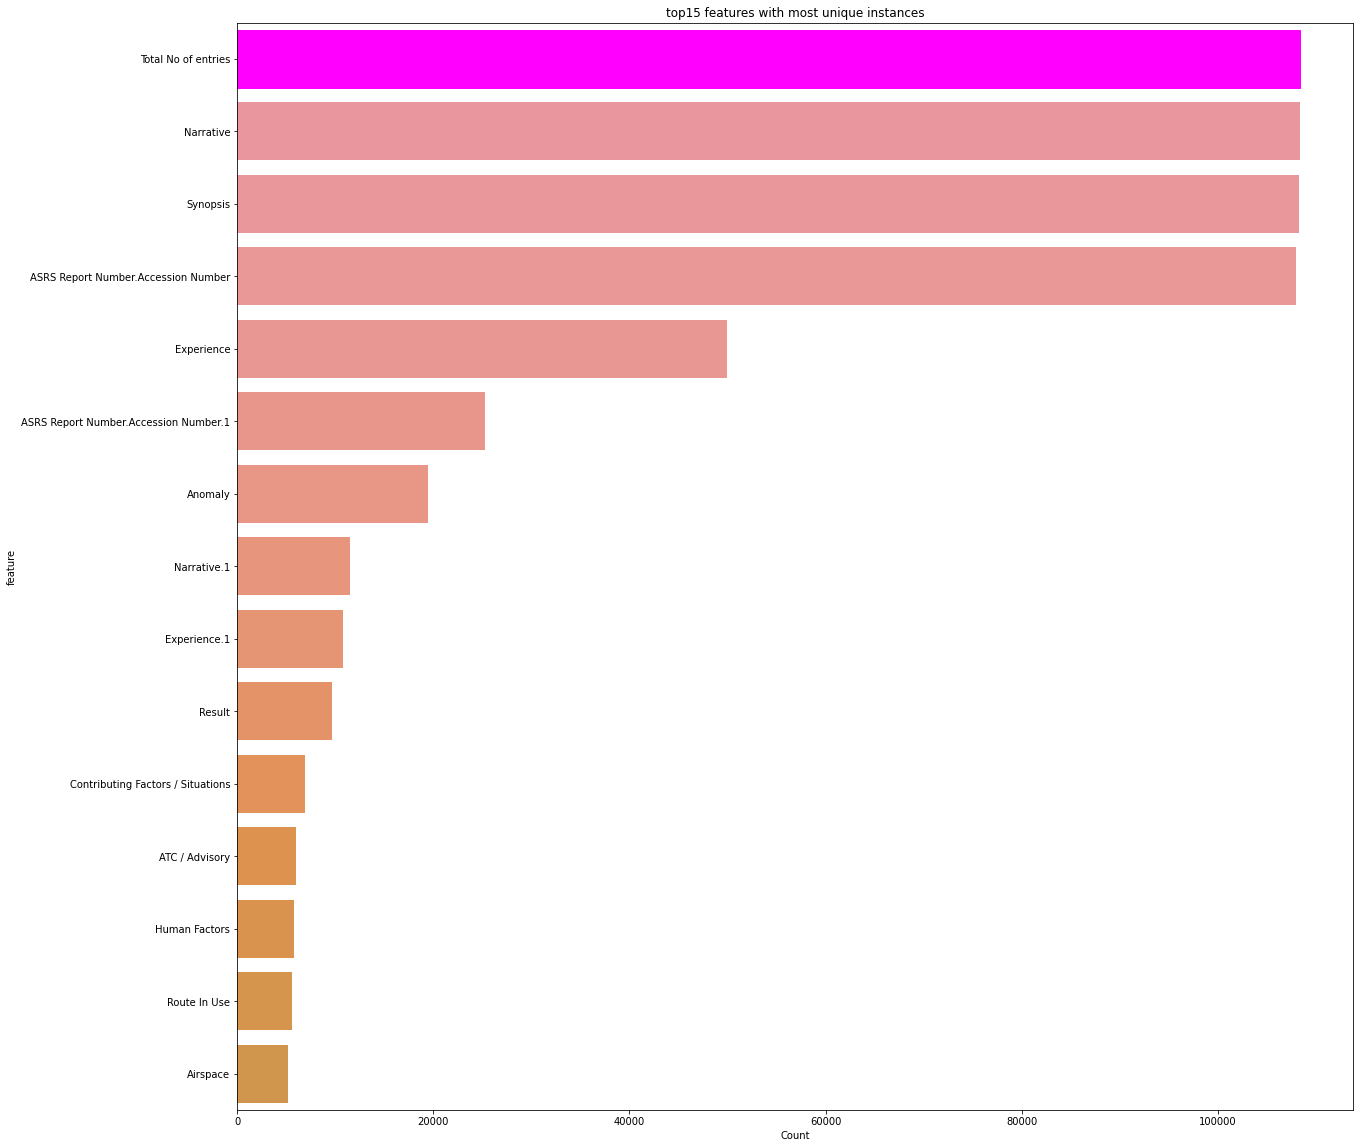

In [ ]:
# Barplot of unique features
fig = plt.figure(figsize = (20,20))
ax = sns.barplot(data = my_df, x = 'unique counts', y = 'feature')

# Color the top bar
for bar in ax.patches:
    if bar.get_y() < 0.5: # get_y() returns the bottom coordinate of the rectangle 
                          # given a vertical bar layout --> here '< 0.5' means the topmost bar
        bar.set_color('magenta')

# Plot the 15 most frequent occurences
topX = 15
plt.ylim(topX - 0.5)
plt.xlabel('Count')
plt.title(f"top{topX} features with most unique instances");

In [ ]:
# Add additional columns to the DataFrame: completetion percentage and scaled number of unique counts
my_df['compl_percent'] = np.round(100 * (1 - (my_df['nan_features'] / my_df['total_entries_feat'])), 1)
my_df['unique_cnts_scaled'] = my_df['unique counts'] / 1000 # scale in thousands, to plot along the percentages
my_df['unique_cnts_percent'] = np.round(my_df['unique counts'] / my_df['total_entries_feat'] * 100, 1) # scale as percentages


# For the next plot below: sort dataframe in descending order of completion percentage
my_df = my_df.sort_values(by = 'compl_percent', ascending = False)

my_df.head()

feature  unique counts  total_entries_feat  \
119                            Narrative         108389            108407.0   
0                                   Date            243            108407.0   
3                        State Reference             68            108407.0   
123                             Synopsis         108256            108407.0   
99   ASRS Report Number.Accession Number         107981            108407.0   

     nan_features  compl_percent  unique_cnts_scaled  unique_cnts_percent  
119           0.0          100.0             108.389                100.0  
0             0.0          100.0               0.243                  0.2  
3             0.0          100.0               0.068                  0.1  
123          11.0          100.0             108.256                 99.9  
99          312.0           99.7             107.981                 99.6

### BOKEH PLOT - cnts in percent

In [ ]:
# BOKEH PLOT

source = ColumnDataSource(my_df)

f = figure(width = 1800, height = 600, x_range = my_df['feature'])
f.xaxis.major_label_orientation = np.pi/2
f.yaxis.major_label_orientation = np.pi/2


abcisses1 = dodge(field_name = 'feature', value = -0.25, range = f.x_range)
abcisses2 = dodge(field_name = 'feature', value = 0, range = f.x_range)
#abcisses3 = dodge(field_name = 'x', value = 0.25, range = f.x_range)

v1 = f.vbar(source = source, x = abcisses1, top = 'unique_cnts_percent', width = 0.2, color = 'blue', legend_label = "unique counts [%]")
v2 = f.vbar(source = source, x = abcisses2, top = 'compl_percent', width = 0.2, color = 'green', legend_label = "completion percentage (how many NaN's)")
#v3 = f.vbar(source = source, x = abcisses3, top = 'valeur 3', width = 0.2, color = 'blue', legend_label = "Valeur 3")

# Create HoverTool
h = HoverTool(renderers = [v1, v2],  # liste de GlyphRenderer avec lesquels on veut intéragir
    
              tooltips = [( "feature", "@feature"), 
                          ("unique counts [%]", "@unique_cnts_percent"),
                          ("completeness percentage", "@compl_percent")
                          ]) # liste de couples d'informations à afficher à coté du point survolé. Les informations que nous affichons sont les coordonnées du point survolé.  
f.add_tools(h)
f.legend.location ='center'
# f.legend.visible=False # hide the legend
show(f)

### BOKEH PLOT - absolute cnts

In [ ]:
# BOKEH PLOT

source = ColumnDataSource(my_df)

f = figure(width = 1800, height = 600, x_range = my_df['feature'])
f.xaxis.major_label_orientation = np.pi/2
f.yaxis.major_label_orientation = np.pi/2


abcisses1 = dodge(field_name = 'feature', value = -0.25, range = f.x_range)
abcisses2 = dodge(field_name = 'feature', value = 0, range = f.x_range)
#abcisses3 = dodge(field_name = 'x', value = 0.25, range = f.x_range)

v1 = f.vbar(source = source, x = abcisses1, top = 'unique_cnts_scaled', width = 0.2, color = 'blue', legend_label = "unique counts [thousands]")
v2 = f.vbar(source = source, x = abcisses2, top = 'compl_percent', width = 0.2, color = 'green', legend_label = "completion percentage (how many NaN's)")
#v3 = f.vbar(source = source, x = abcisses3, top = 'valeur 3', width = 0.2, color = 'blue', legend_label = "Valeur 3")

# Create HoverTool
h = HoverTool(renderers = [v1, v2],  # liste de GlyphRenderer avec lesquels on veut intéragir
    
              tooltips = [( "feature", "@feature"), 
                          ("unique counts [thousands]", "@unique_cnts_scaled"),
                          ("completeness percentage", "@compl_percent")
                          ]) # liste de couples d'informations à afficher à coté du point survolé. Les informations que nous affichons sont les coordonnées du point survolé.  
f.add_tools(h)
f.legend.location ='center'
# f.legend.visible=False # hide the legend
show(f)

## Flag of completion for categories "Aircraft 2" "Person 2" and "Report 2"

In [ ]:
print(df.shape)
category_list_to_study=['Aircraft 2','Person 2','Report 2']
category_list_to_study_col=[]
for category in category_list_to_study:
    category_columns_list=DF_Dictionary[DF_Dictionary['Category']==category].loc[:,'Column']
    all_null=df.loc[:,category_columns_list].isna().all(axis = 1) 
    col='Theme_'+category+'_completion'
    category_list_to_study_col.append(col)
    df[col]=all_null.astype('str').apply(lambda x: 'Empty' if x=='True' else 'At least 1 data')
print(df.shape)

(108407, 124)
(108407, 127)


In [ ]:
pd.crosstab(df['Theme_Person 2_completion'],df['Theme_Report 2_completion'], rownames=['Person 2'], colnames=['Report 2'])
# Report 2 is probably written by Person 2 (no Report 2 for entries without Person 2 data)

Report 2         At least 1 data  Empty
Person 2                               
At least 1 data            14843  36587
Empty                          1  56976

In [ ]:
pd.crosstab(df['Theme_Aircraft 2_completion'],df['Theme_Person 2_completion'], rownames=['Aircraft 2'], colnames=['Person 2'])
# Aircraft 2 and Person 2 are independant : there are entries for Person 2 without Aircraft 2 data and vice versa

Person 2         At least 1 data  Empty
Aircraft 2                             
At least 1 data            11248   9735
Empty                      40182  47242

In [ ]:
pd.crosstab(df['Theme_Aircraft 2_completion'],df['Theme_Report 2_completion'], rownames=['Aircraft 2'], colnames=['Report 2'])
# Aircraft 2 and Report 2 are independant : there are entries for Report 2 without Aircraft 2 data and vice versa

Report 2         At least 1 data  Empty
Aircraft 2                             
At least 1 data             2151  18832
Empty                      12693  74731

In [ ]:
df=df.drop(category_list_to_study_col,axis=1)
print(df.shape)

(108407, 124)


# FEATURE ENGINEERING

## Create 'Year' feature

In [ ]:
df.Date.value_counts()
# The 'Date' feature contains 'AAAAMM' dates (for anonymisation issues)
# See in the tail : that for 2005 and 2006, a few entries had the date with only 'AAAA'

200203    848
200201    808
200310    785
200306    761
200202    744
200311    732
200305    720
200304    716
200807    710
200303    707
200204    704
200307    684
200607    664
200208    655
200610    652
200308    647
200806    645
200309    641
200205    637
201911    622
200405    622
200606    620
200805    616
200608    615
201507    603
200907    601
201909    595
201910    590
200410    589
200611    586
200804    586
200301    576
200302    575
200612    571
201111    569
201612    567
201907    565
200312    560
200803    559
200210    558
201908    557
201511    556
201812    554
201110    549
201508    545
202007    541
200403    540
200409    540
200605    537
200604    536
200404    532
200811    528
200603    528
201604    527
200408    525
200808    515
200401    512
200407    510
201003    506
201506    503
201901    503
200411    497
201810    497
201007    496
200906    496
201701    496
201106    495
200406    491
200609    490
201512    490
200810    489
201906

In [ ]:
df['Year']=df.Date.astype(str).apply(lambda x :  x if  len(x)==4 else int(x[:-2]) ).astype(int) 

In [ ]:
# Check : OK
functions_to_apply = {
    'Date' : ['min', 'max']}
df.groupby('Year').agg(functions_to_apply)


Date        
         min     max
Year                
2002  200201  200212
2003  200301  200312
2004  200401  200412
2005    2005  200512
2006    2006  200612
2007  200701  200712
2008  200801  200812
2009  200901  200912
2010  201001  201012
2011  201101  201112
2012  201201  201212
2013  201301  201312
2014  201401  201412
2015  201501  201512
2016  201601  201612
2017  201701  201712
2018  201801  201812
2019  201901  201912
2020  202001  202012
2021  202101  202112
2022  202201  202201

## Merge Stat_Reference_df & Create 'State' features

In [ ]:
df=df.merge(right=Stat_Reference_df, on = ['State Reference'], how='inner')

In [ ]:
df.shape

(108407, 127)

- Nouvelle colonne 'State Location Known' : False si State Referebce =  US or FO , True sinon

In [ ]:
df['State Location Known']=df['State Reference'].apply(lambda s :  False if  s in ('US','FO') else True )  

# DATA DISCOVERY

## Quantitative data

### Statistics

In [ ]:
# "Quantitative" data description (including ACN, ASRS Number and ASRS Number.1 = IDs)
df.describe().T
# We can see empty columns in the '.1' colummns = second report data


count          mean  \
Date                                          108407.0  2.010913e+05   
Relative Position.Angle.Radial                  6084.0  1.836988e+02   
Relative Position.Distance.Nautical Miles      26593.0  1.471161e+01   
Altitude.MSL.Single Value                      49893.0  1.273897e+04   
Latitude / Longitude (UAS)                         0.0           NaN   
Crew Size                                      98916.0  1.831291e+00   
Number Of Seats.Number                           554.0  1.579531e+02   
Passengers On Board.Number                       472.0  1.210530e+02   
Crew Size Flight Attendant.Number Of Crew        149.0  5.006711e+00   
Aircraft Zone.1                                    0.0           NaN   
Crew Size.1                                    14467.0  1.632750e+00   
Maintenance Status.Records Complete.1              0.0           NaN   
Number Of Seats.Number.1                           6.0  1.610000e+02   
Passengers On Board.Number.1                       4.0  1.452500e+02   
Crew Size Flight Attendant.Number Of Crew.1        0.0           NaN   
Airspace Authorization Provider (UAS).1            0.0           NaN   
Airworthiness Certification (UAS).1                0.0           NaN   
Flight Operated with Visual Observer (UAS).1       0.0           NaN   
Control Mode (UAS).1                               0.0           NaN   
Passenger Capable (UAS).1                          0.0           NaN   
Type (UAS).1                                       0.0           NaN   
ASRS Report Number.Accession Number           108095.0  1.118967e+06   
ASRS Report Number.Accession Number.1          25262.0  3.246136e+07   
Year                                          108407.0  2.010921e+03   

                                                       std     min        25%  \
Date                                          1.344898e+03  2005.0  200605.00   
Relative Position.Angle.Radial                1.061591e+02     0.0      90.00   
Relative Position.Distance.Nautical Miles     6.001108e+01     0.0       0.00   
Altitude.MSL.Single Value                     1.279581e+04     0.0    3000.00   
Latitude / Longitude (UAS)                             NaN     NaN        NaN   
Crew Size                                     4.875707e-01     0.0       2.00   
Number Of Seats.Number                        5.729188e+01     0.0     129.00   
Passengers On Board.Number                    6.912977e+01     0.0      71.50   
Crew Size Flight Attendant.Number Of Crew     3.392154e+00     1.0       3.00   
Aircraft Zone.1                                        NaN     NaN        NaN   
Crew Size.1                                   5.372739e-01     0.0       1.00   
Maintenance Status.Records Complete.1                  NaN     NaN        NaN   
Number Of Seats.Number.1                      9.001555e+01     3.0     140.75   
Passengers On Board.Number.1                  4.574841e+01   100.0     117.25   
Crew Size Flight Attendant.Number Of Crew.1            NaN     NaN        NaN   
Airspace Authorization Provider (UAS).1                NaN     NaN        NaN   
Airworthiness Certification (UAS).1                    NaN     NaN        NaN   
Flight Operated with Visual Observer (UAS).1           NaN     NaN        NaN   
Control Mode (UAS).1                                   NaN     NaN        NaN   
Passenger Capable (UAS).1                              NaN     NaN        NaN   
Type (UAS).1                                           NaN     NaN        NaN   
ASRS Report Number.Accession Number           2.166909e+07     7.0  699168.00   
ASRS Report Number.Accession Number.1         4.941847e+09     1.0  716076.00   
Year                                          5.883475e+00  2002.0    2006.00   

                                                   50%         75%  \
Date                                          201102.0   201607.00   
Relative Position.Angle.Radial                   180.0      270.00   
Relative Pos

### YANNIS: Correlation matrix

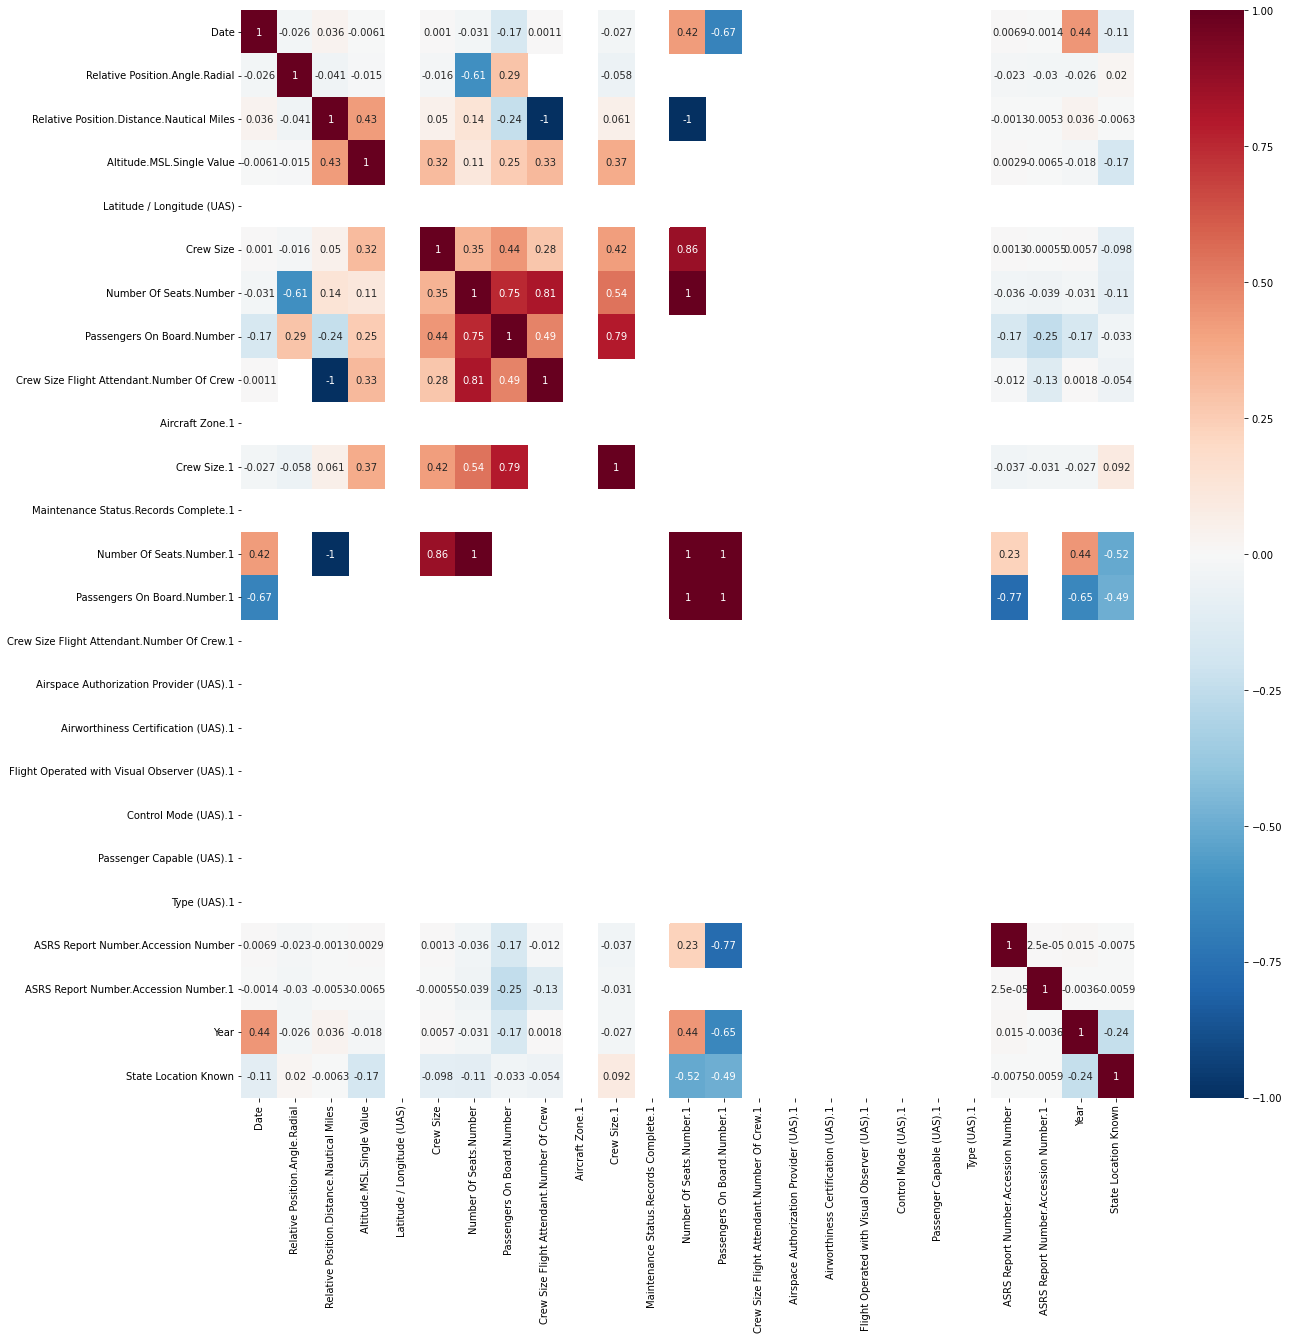

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, cmap='RdBu_r', center=0);

## Qualitative data analysis

In [ ]:
# CLassification of variables according to their role
df_cat_data=df.select_dtypes(include='O').drop(['Narrative','Narrative.1','Callback','Callback.1','Synopsis'], axis = 1)  # ou cat_data=df.select_dtypes(include='object')
df_cat_data.shape

(108407, 98)

### Top 20 modalities

In [ ]:
nb_null=0
nb_entries=len(df_cat_data)
N=20 # Nbr of rows in the top
for col in df_cat_data.columns :
    print("\n")
    print("VARIABLE : ",col, )
    nb_null=df_cat_data[col].isnull().sum(axis = 0)
    print('NaN VALUES : ',nb_null , '   (',round(nb_null/nb_entries*100,2),'%)    /     Non NaN VALUES : ',nb_entries-nb_null ,'  (',round((nb_entries-nb_null)/nb_entries*100,2),'%)')
    S=df_cat_data[col].value_counts(dropna=True, normalize=False)
    print("    Nbr of modalities (excluding Nan) : ",len(S) )
    S2=df_cat_data[col].value_counts(dropna=False, normalize=False)
    S_topN=S2.head(N)
    print('TOP ',len(S_topN) ,'MODALITIES',S_topN.sum(), '   (',round(S_topN.sum()/nb_entries*100,2),'%)' )
    print(S_topN)    
    
# Certaines variables sont à parser (à lister) avant le value_counts comme 'Weather Elements / Visibility' (cf cellule suivante)



VARIABLE :  Local Time Of Day
NaN VALUES :  8579    ( 7.91 %)    /     Non NaN VALUES :  99828   ( 92.09 %)
    Nbr of modalities (excluding Nan) :  5
TOP  6 MODALITIES 108407    ( 100.0 %)
1201-1800    38475
0601-1200    28931
1801-2400    22198
0001-0600    10201
NaN           8579
ZZZ             23
Name: Local Time Of Day, dtype: int64


VARIABLE :  Locale Reference
NaN VALUES :  815    ( 0.75 %)    /     Non NaN VALUES :  107592   ( 99.25 %)
    Nbr of modalities (excluding Nan) :  4910
TOP  20 MODALITIES 61341    ( 56.58 %)
ZZZ.Airport     38769
ZZZ.ARTCC        5272
ZZZZ.Airport     2055
ZZZ.TRACON       1902
ORD.Airport      1444
LAX.Airport      1192
TEB.Airport      1056
DFW.Airport      1023
DEN.Airport       938
SFO.Airport       929
LAS.Airport       864
ATL.Airport       840
NaN               815
ZZZ.Tower         741
ZZZZ.ARTCC        644
LGA.Airport       617
EWR.Airport       616
PHL.Airport       559
MIA.Airport       544
JFK.Airport       521
Name: Locale Reference

### Analysis of Nbr of modalities per year for all categorical features

In [ ]:
years=list(range(min(df['Year']),max(df['Year']+1)))
years

[2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [ ]:
# Definition of DF counting the # of features'modalities per year
# Initialization of a DF with the studied years

df_len_multiple = pd.DataFrame(years, columns = ['Year'])
df_len_multiple['Year']=df_len_multiple['Year'].astype(int)

In [ ]:
#
cat_features_list=df.select_dtypes(include='O').drop(['Narrative','Narrative.1','Callback','Callback.1','Synopsis'], axis = 1).columns # ou cat_data=df.select_dtypes(include='object')

for cat_feature in cat_features_list:
    list_len=[]
    for y in years:
        df_year=df[df['Year']==y]
        Feature_split=df_year[cat_feature].astype(str).str.split('; ', expand=True).stack().reset_index(drop=True)
        Feature_split=pd.DataFrame(Feature_split).rename(columns={0:'Col'})
        Feature_split=Feature_split.drop_duplicates()
        Feature_split=Feature_split.sort_values(by='Col', ascending = True)
        list_len.append(len(Feature_split))

    df_len_multiple=pd.concat([df_len_multiple, pd.DataFrame(list_len, columns = [cat_feature+' Modality count'])],axis = 1)

df_len_multiple

Year  Local Time Of Day Modality count  Locale Reference Modality count  \
0   2002                                 5                             1526   
1   2003                                 5                             1581   
2   2004                                 5                             1410   
3   2005                                 5                              763   
4   2006                                 5                             1345   
5   2007                                 5                              940   
6   2008                                 5                              863   
7   2009                                 6                              710   
8   2010                                 5                              639   
9   2011                                 6                              669   
10  2012                                 6                              605   
11  2013                                 6                              543   
12  2014                                 5                              698   
13  2015                                 5                              875   
14  2016                                 5                              725   
15  2017                                 6                              739   
16  2018                                 6                              764   
17  2019                                 6                              673   
18  2020                                 6                              539   
19  2021                                 5                              573   
20  2022                                 5                               81   

    State Reference Modality count  Altitude.AGL.Single Value Modality count  \
0                               62                                        60   
1                               64                                        65   
2                               64                                        55   
3                               58                                        47   
4                               61                                        78   
5                               61                                        97   
6                               62                                        67   
7                               61                                        64   
8                               59                                        50   
9                               60                                        43   
10                              59                                        49   
11                              59                                        50   
12                              61                                        45   
13                              62                                        55   
14                              61                                        58   
15                              60                                        51   
16                              61                                        63   
17                              58                                        66   
18                              60                                        53   
19                              57                                        84   
20                              24                                        19   

    Flight Conditions Modality count  \
0                                  5   
1                                  5   
2                                  5   
3                                  5   
4                                  5   
5                                  5   
6                                  5   
7                                  5   
8                                  5   
9                                  5   
10                                 5   
11                      

#### Focus on 'Anomaly feature

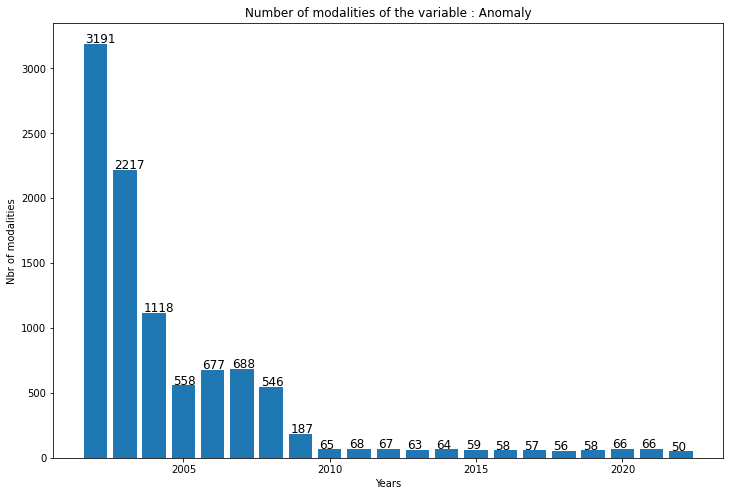

In [ ]:
plt.figure( figsize= (12, 8) ) 
plt.bar(df_len_multiple['Year'],df_len_multiple['Anomaly Modality count'])
plt.title('Number of modalities of the variable : Anomaly')
plt.xlabel('Years')
plt.ylabel('Nbr of modalities')
for y, v in zip(df_len_multiple['Year'],df_len_multiple['Anomaly Modality count']):
  plt.text(y-0.35 , v+35           # si bar au lieu de barh : inverser v et i
            ,str(v)
            , color='black'
            , fontsize = 12
          ,va='center');


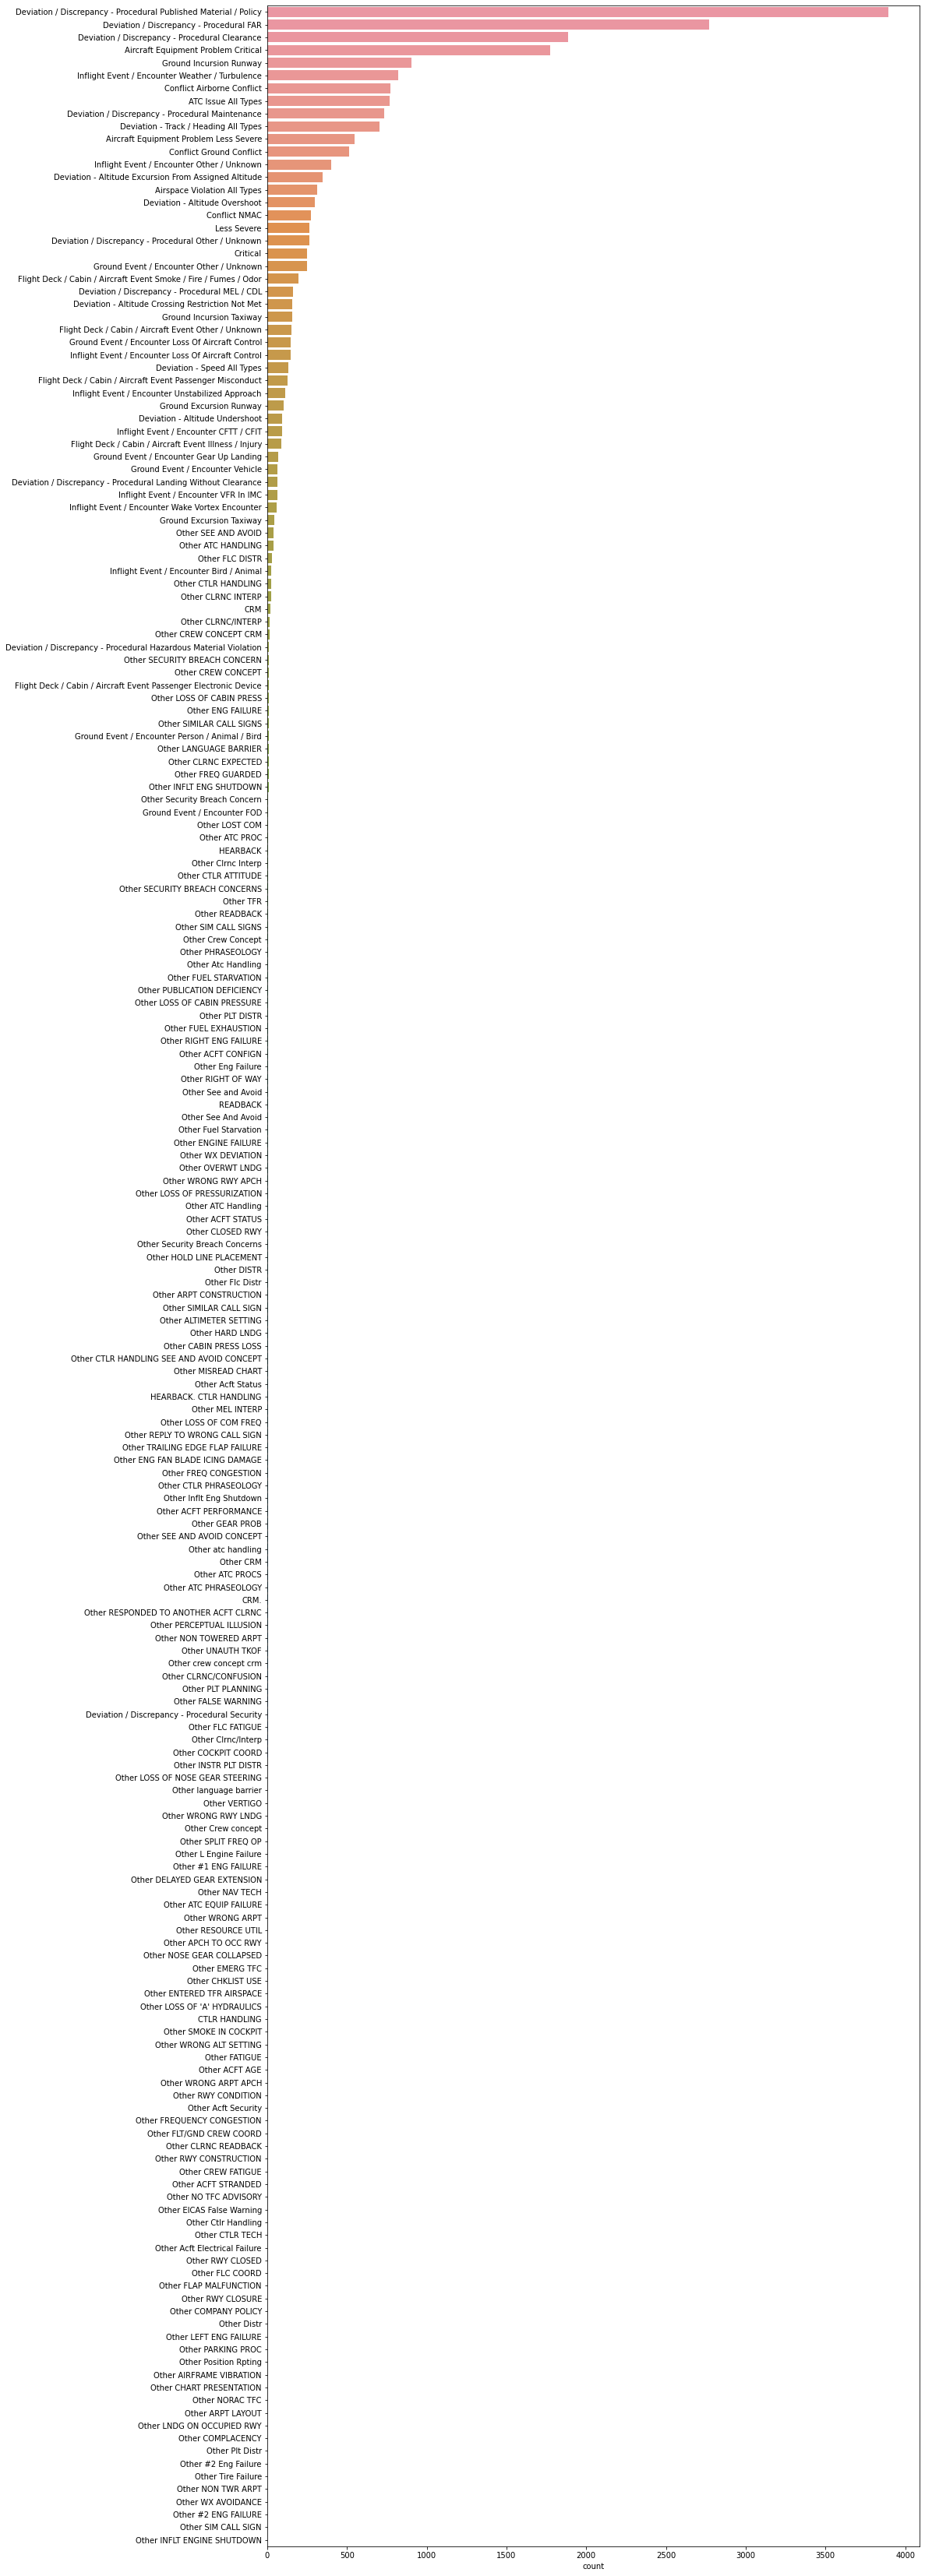

In [ ]:
# 'Anomaly' column parsing & Top modalities in 2002
Anomaly=df[df['Year']==2002]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
fig, ax = plt.subplots(figsize=(15,60))
sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:200].index);

# High number of very low populated "textual" modalities (see bottom)

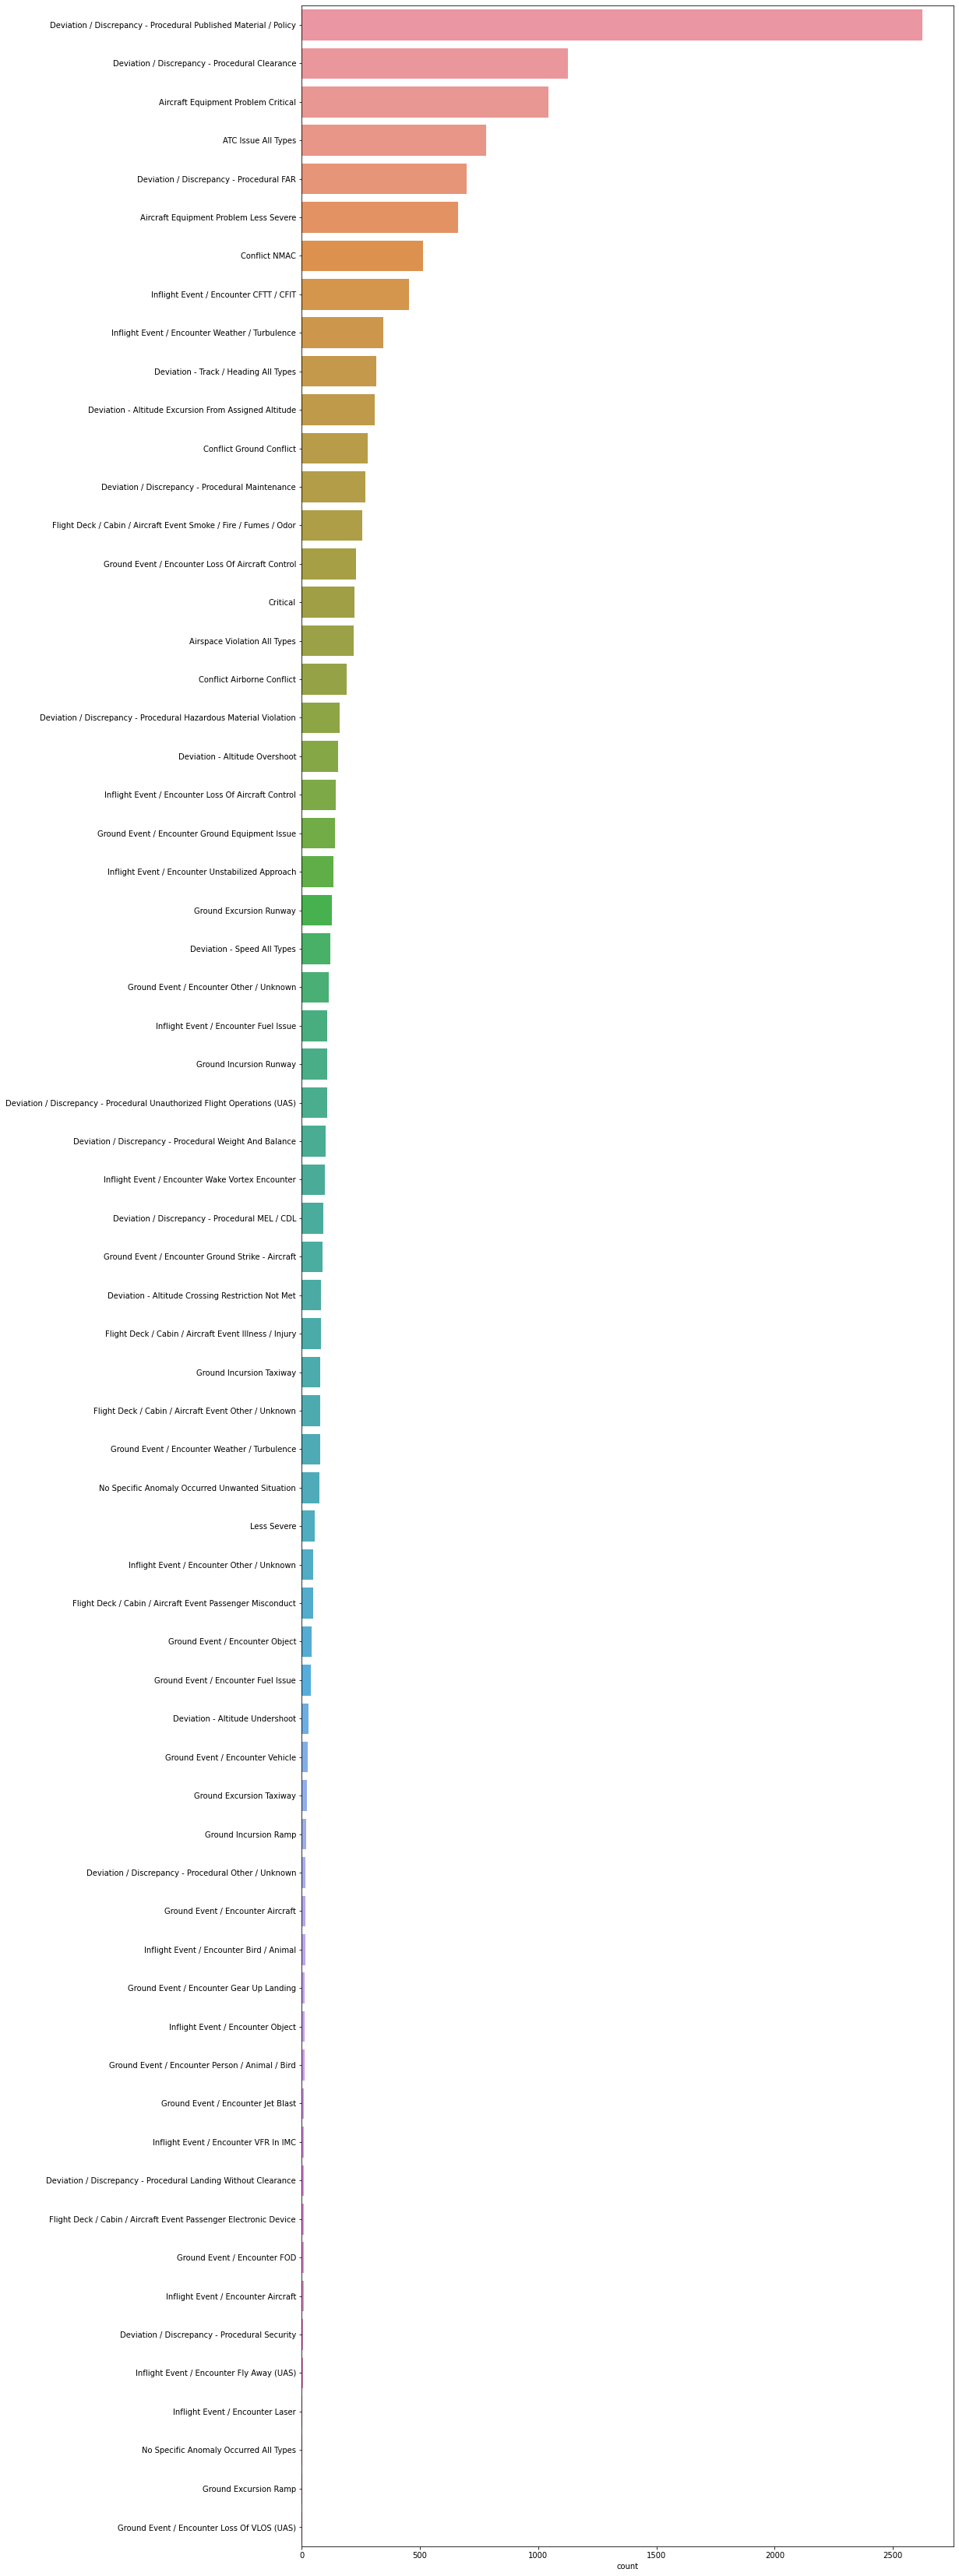

In [ ]:
# 'Anomaly' column parsing & Top modalities in 2021
Anomaly=df[df['Year']==2021]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
fig, ax = plt.subplots(figsize=(15,60))
sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:200].index);

# Fewer modalities, populated with descrepancies, with a hierarchical structure (see ASRS coding forms)


## Textual data analysis

In [ ]:
# CLassification of variables according to their role
df_text_data=df.loc[:,['Narrative','Narrative.1','Callback','Callback.1','Synopsis']]  
df_text_data.shape
#(108407, 96)

(108407, 5)

In [ ]:
nb_null=0
nb_entries=len(df_text_data)
N=20 # Nbr of rows in the top
for col in df_text_data.columns :
    print("\n")
    print("VARIABLE : ",col, )
    nb_null=df_text_data[col].isnull().sum(axis = 0)
    print('VALEURS NaN : ',nb_null , '   (',round(nb_null/nb_entries*100,2),'%)    /      VALEURS NON VIDES : ',nb_entries-nb_null ,'  (',round((nb_entries-nb_null)/nb_entries*100,2),'%)')
    S=df_text_data[col].value_counts(dropna=True, normalize=False)
    print("    Nombre de modalités (hors Nan) : ",len(S) )
    S2=df_text_data[col].value_counts(dropna=False, normalize=False)
    S_topN=S2.head(N)
    print('TOP ',len(S_topN) ,'VALEURS',S_topN.sum(), '   (',round(S_topN.sum()/nb_entries*100,2),'%)' )
    print(S_topN)    
    
 



VARIABLE :  Narrative
VALEURS NaN :  0    ( 0.0 %)    /      VALEURS NON VIDES :  108407   ( 100.0 %)
    Nombre de modalités (hors Nan) :  108389
TOP  20 VALEURS 38    ( 0.04 %)
SAFETY IS BEING COMPROMISED BECAUSE OF REDUCTION OF STAFFING ON THE XA15 TO XI15 SHIFT MONDAY THRU FRIDAY. THE SOUTH AREA CONSISTS OF SEVEN SECTORS; THREE HIGH ALT SECTORS AND FOUR LOW ALT SECTORS. THEY CONTROL OVER-FLT TFC AS WELL AS INBOUND TFC TO SEVERAL ARPTS. MANAGEMENT HAS DECIDED TO REDUCE THE STAFFING ON THIS SHIFT FROM FOUR CTLRS TO THREE CTLRS. THE FOLLOWING REASONS ARE WHY IT IS UNSAFE TO REDUCE THE SHIFT STAFFING IN THE ZME/SOUTH AREA: 1) THE AREA WORKS AND PROVIDES IN-TRAIL SPACING FOR MEM ARRS FROM THE SOUTHWEST OVER THE UJM ARR GATE. THE ARRS LAST UNTIL XD30 LCL AND WHEN MEM IS IN A SOUTH CONFIGURATION IT IS NOT UNCOMMON FOR THE AREA TO HAVE TO HOLD SEVERAL OF THESE ARRS. NORMALLY; THIS HOLDING OCCURS AFTER XC00 LCL. 2) THE AREA ALSO ASSUMES THE RESPONSIBILITIES OF TWO APCH CTLS; JAN AND MEI. 

#DATAVIZ

## Time analysis

In [ ]:
import seaborn as sns
sns.set_theme() 
sns.set_style('whitegrid')

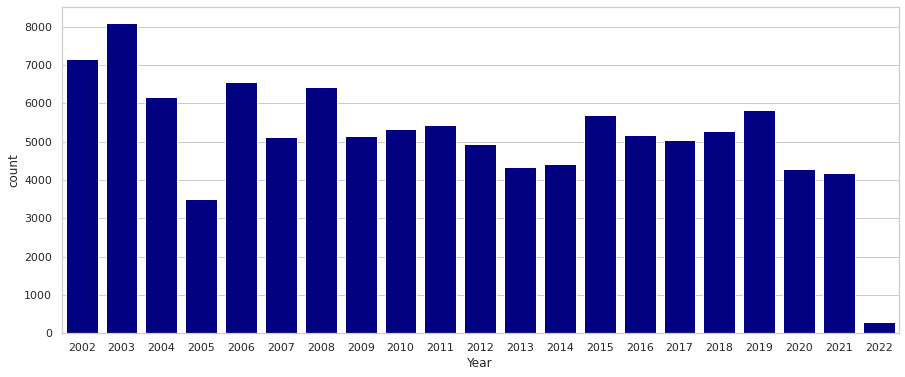

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(x=df['Year'],color="navy",saturation=1,ax=ax);

# A volume decrease in the start of the period and then a plateau , up to 2020/2021 due to COVID context 
# 2022 : data extraction ends at 2022/01
# Drop in 2005 : explanation ?

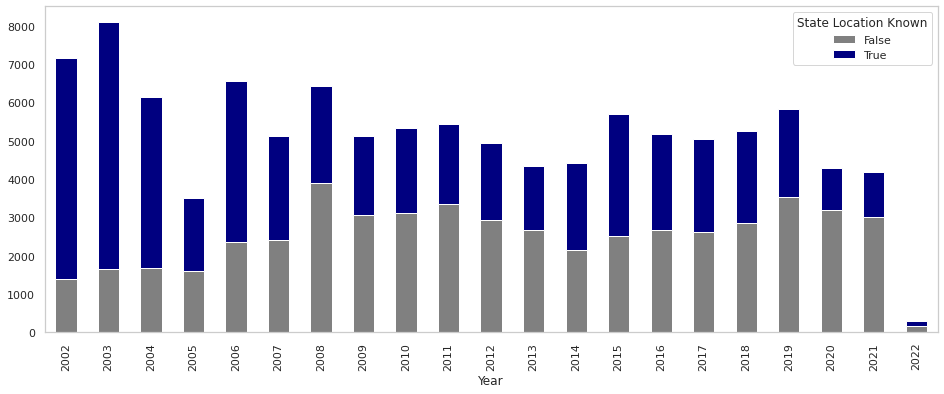

In [ ]:
df_plot = df.groupby(['Year', 'State Location Known']).size().reset_index().pivot(columns='State Location Known', index='Year', values=0)
fig, ax = plt.subplots(figsize=(16,6))
df_plot.plot(kind='bar', color = ['grey', 'navy'], stacked=True,ax=ax)
plt.grid(False);


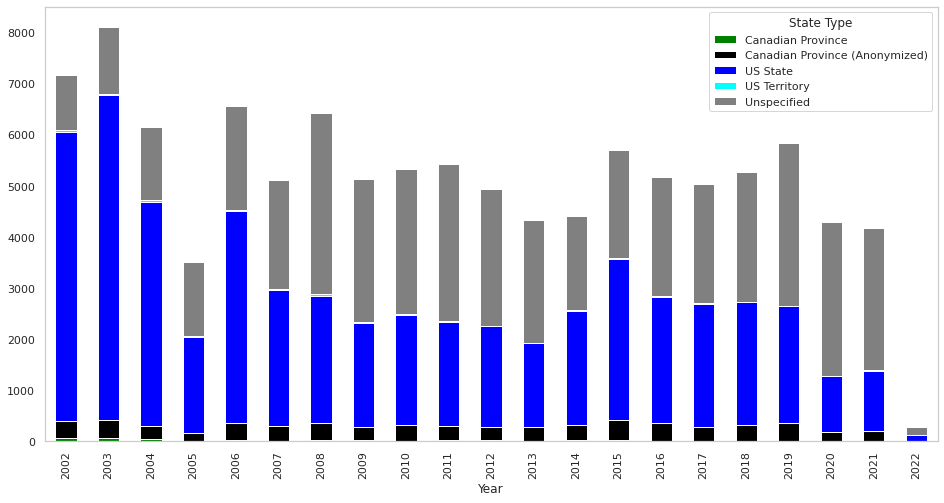

In [ ]:
df_plot = df.groupby(['Year', 'State Type']).size().reset_index().pivot(columns='State Type', index='Year', values=0)
fig, ax = plt.subplots(figsize=(16,8))
df_plot.plot(kind='bar', color = ['green','black','blue','cyan','grey' ], stacked=True,ax=ax)
plt.grid(False);

## Candidate target variables

### Primary Problem

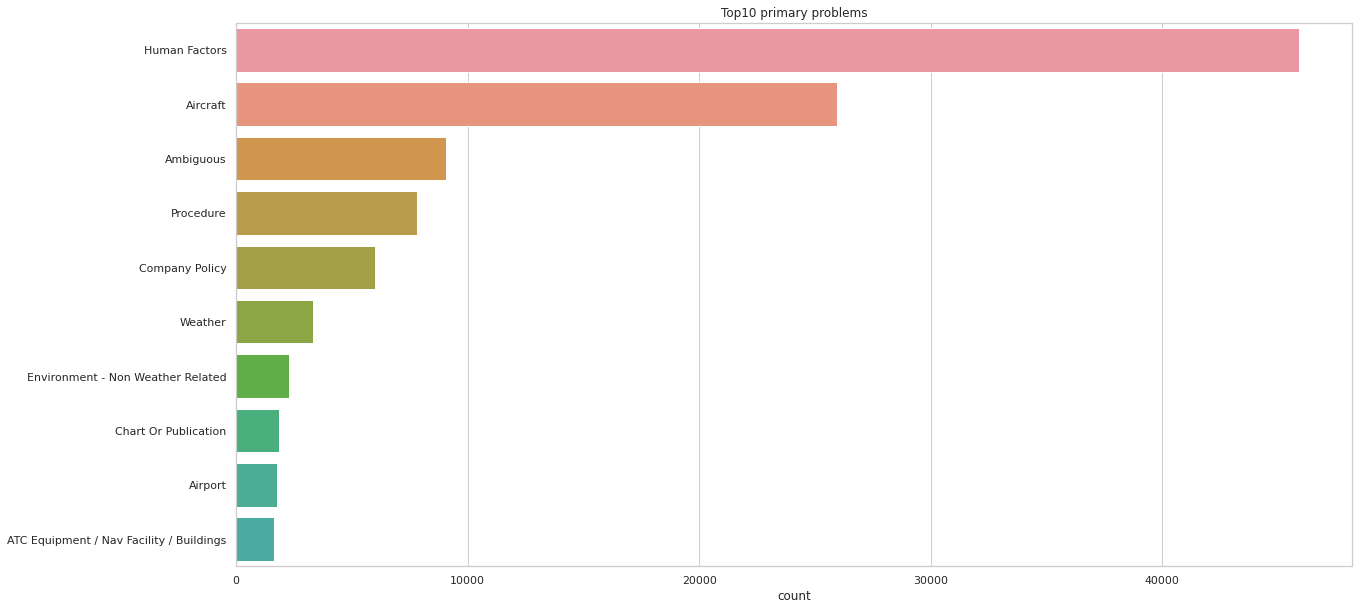

In [ ]:
# Instantiate new figure
fig = plt.figure(figsize= (20,10))
ax = fig.add_subplot(111) # need the ax handle to set the ylabels to None

# Plot in decreasing order
sns.countplot(y = df['Primary Problem'], 
              order = df['Primary Problem'].value_counts().index, 
              orient = 'h')

# Plot settings
plt.title('Top10 primary problems')
ax.set(ylabel = None)
# Plot the 10 most frequent occurences
topX = 10
plt.ylim(topX - 0.5);

### Result

In [ ]:
# TAKES ABOUT 3min. to EXECUTE 
# Make a list of all 'Result' entries by splitting at each ';'
result = list()
for entry in df['Result']:
    split = str(entry).split(sep = '; ') # include a space after ';'
    result = result + split

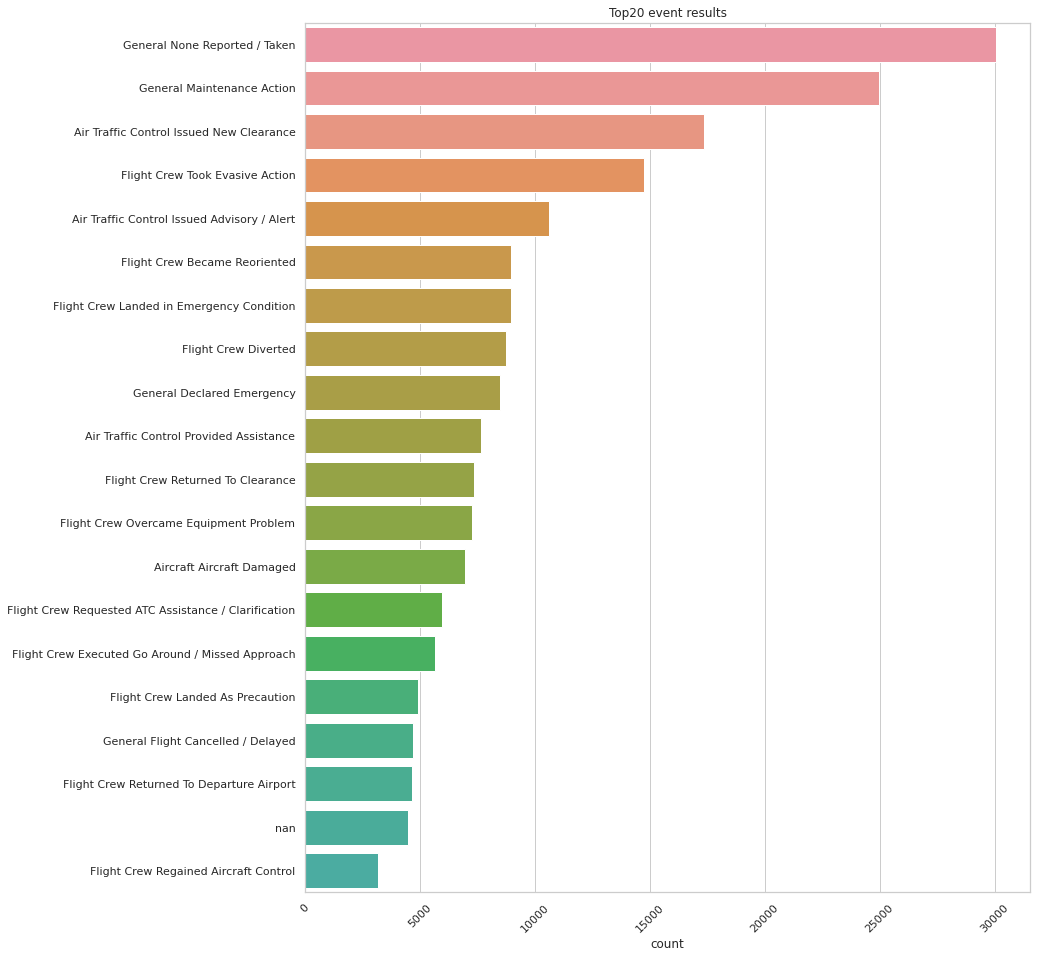

In [ ]:
# Countplot:
fig = plt.figure(figsize= (13,16))

sns.countplot(y = result, 
              order= pd.Series(result).value_counts().index,  # need to transform list to pd.Series for the ordering in countplot()
              orient = 'h')

# Plot the 20 most frequent occurences
topX = 20
plt.ylim(topX - 0.5)

plt.xticks(rotation=45)
plt.title('Top20 event results');

### Human Factors

In [ ]:
# TAKES ABOUT 2min. to EXECUTE 
# Make a list of all 'Human Factor' entries by spliting at each ';'
hum_facts = list()
for entry in df['Human Factors']:
    split = str(entry).split(sep = '; ') # include a space after ';'
    hum_facts = hum_facts + split

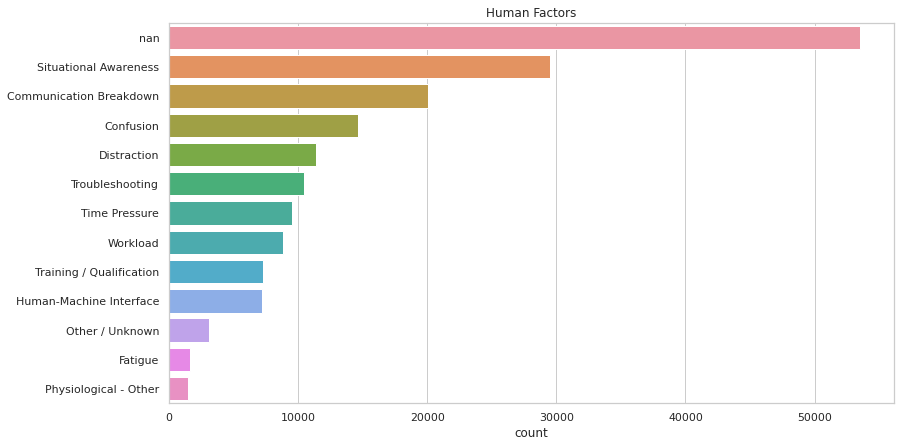

In [ ]:
# Countplot:
fig = plt.figure(figsize= (13,7))

# # Plot in decreasing order
sns.countplot(y = hum_facts, 
              order= pd.Series(hum_facts).value_counts().index, # need to transform list to pd.Series for the ordering in countplot()
              orient = 'h') 
plt.title('Human Factors');

### 'Contributing Factors', 'Primary Problem'

Examine the most common 'Contributing Factors / Situations' per 'Primary Problem'

In [ ]:
print("There are", df.isna().sum()['Primary Problem'], "entries with Primary Problem == NaN.")

There are 454 entries with Primary Problem == NaN.


In [ ]:
# List of all Primary Problems in the dataset
# exclude the entries, where 'Primary Problem is NaN'
prim_probs = list(df[df['Primary Problem'].isna() == False]['Primary Problem'].unique())

In [ ]:
contr_fact = list(df['Contributing Factors / Situations'].unique())
print(f"There are {len(contr_fact)} different 'Contributing Factors / Situations'")
contr_fact

There are 6931 different 'Contributing Factors / Situations'


['Human Factors',
 'Weather; Human Factors; Procedure',
 'Procedure; Human Factors',
 'Procedure',
 'ATC Equipment / Nav Facility / Buildings; Airport; Human Factors; Weather',
 'Human Factors; Procedure',
 'ATC Equipment / Nav Facility / Buildings; Aircraft; Procedure',
 'Aircraft; Procedure',
 'Airport; Human Factors; Procedure',
 'Aircraft; Human Factors; Procedure',
 'ATC Equipment / Nav Facility / Buildings; Human Factors; Procedure',
 'Procedure; Aircraft; Environment - Non Weather Related',
 'Human Factors; Aircraft; ATC Equipment / Nav Facility / Buildings; Weather',
 'Procedure; Human Factors; Company Policy; Airport',
 'Environment - Non Weather Related; Procedure',
 'Aircraft; Chart Or Publication; Human Factors; Procedure',
 'Airport; Environment - Non Weather Related; Procedure',
 'Weather; Chart Or Publication; Human Factors',
 'ATC Equipment / Nav Facility / Buildings',
 'Aircraft',
 'Chart Or Publication',
 'Procedure; Human Factors; Airspace Structure',
 'Aircraft; Pro


There are 45896 issues with Human Factors being the Primary Problem.
Among the 45896 issues with Human Factors being the Primary Problem, there are 9 NaN's under 'Contributing Factors / Situations'.

There are 9078 issues with Ambiguous being the Primary Problem.
Among the 9078 issues with Ambiguous being the Primary Problem, there are 4 NaN's under 'Contributing Factors / Situations'.

There are 7834 issues with Procedure being the Primary Problem.
Among the 7834 issues with Procedure being the Primary Problem, there are 0 NaN's under 'Contributing Factors / Situations'.

There are 25964 issues with Aircraft being the Primary Problem.
Among the 25964 issues with Aircraft being the Primary Problem, there are 9 NaN's under 'Contributing Factors / Situations'.

There are 1624 issues with ATC Equipment / Nav Facility / Buildings being the Primary Problem.
Among the 1624 issues with ATC Equipment / Nav Facility / Buildings being the Primary Problem, there are 0 NaN's under 'Contributing F

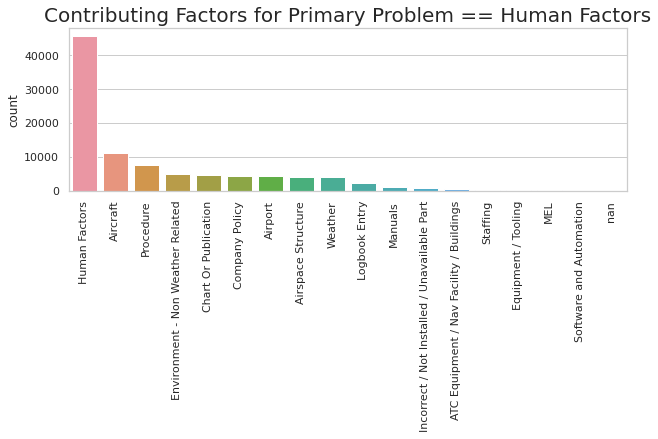

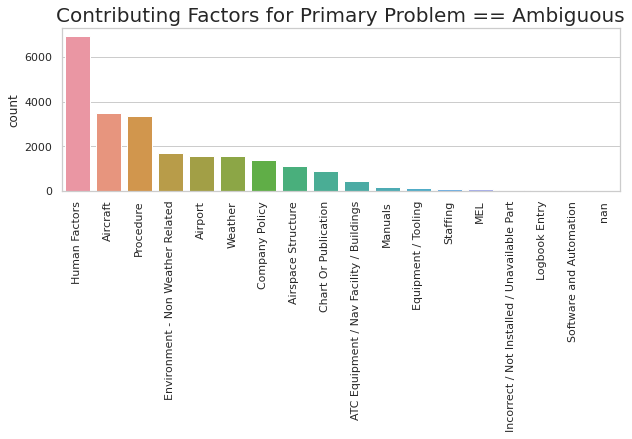

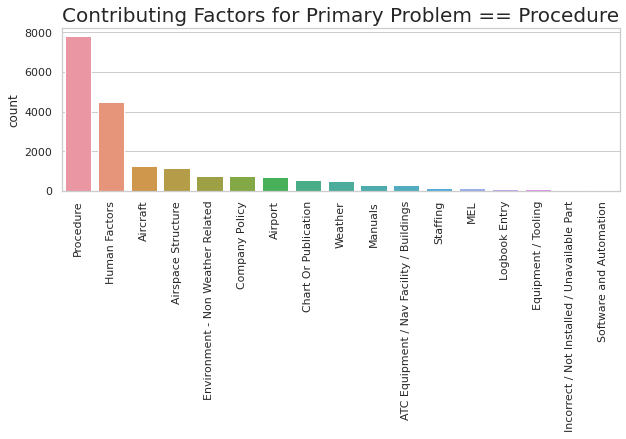

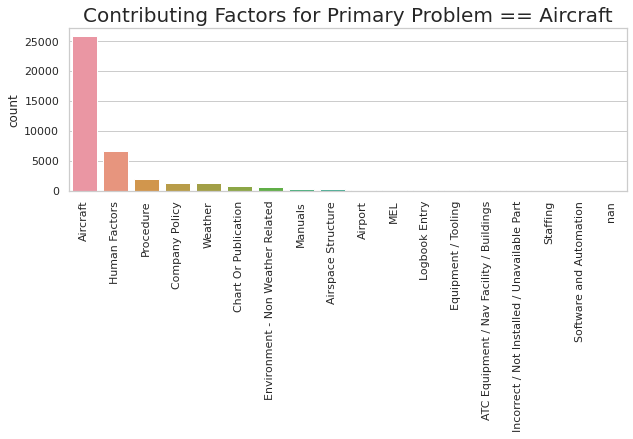

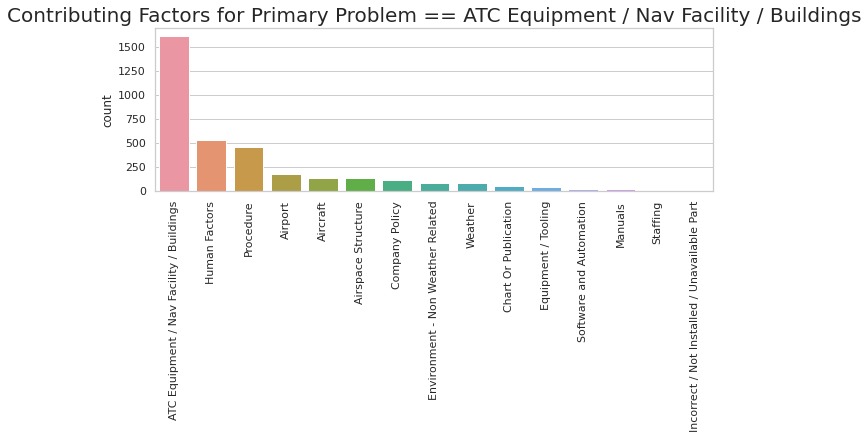

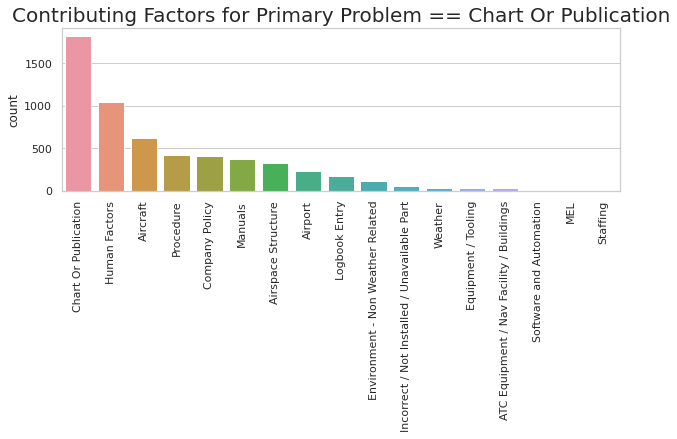

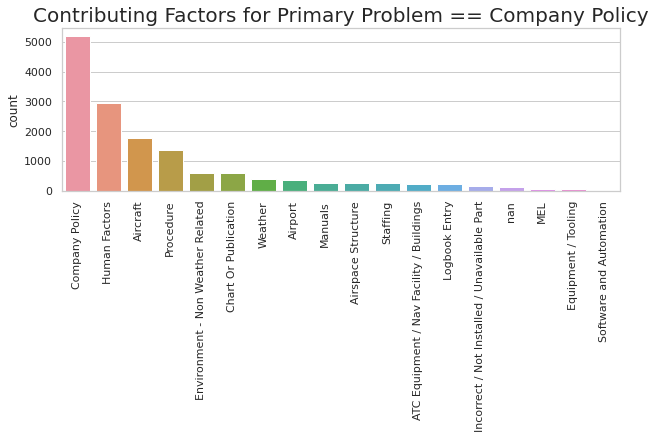

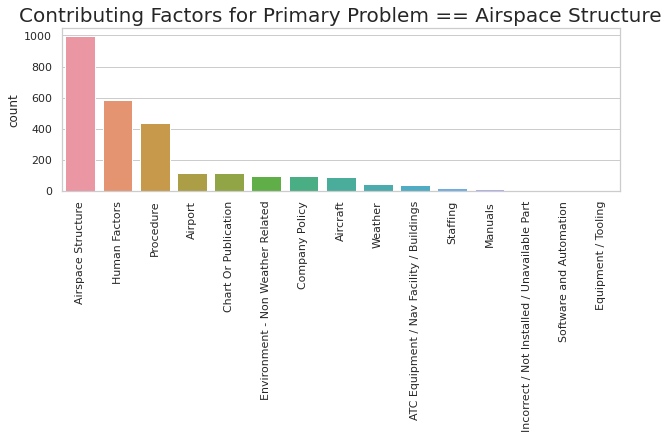

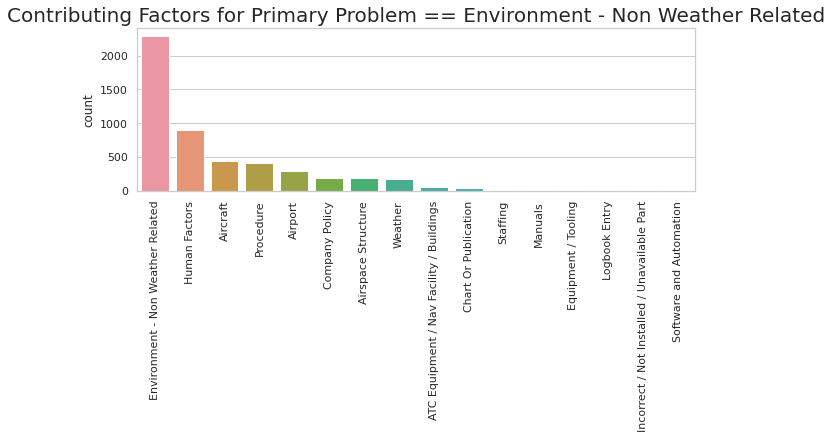

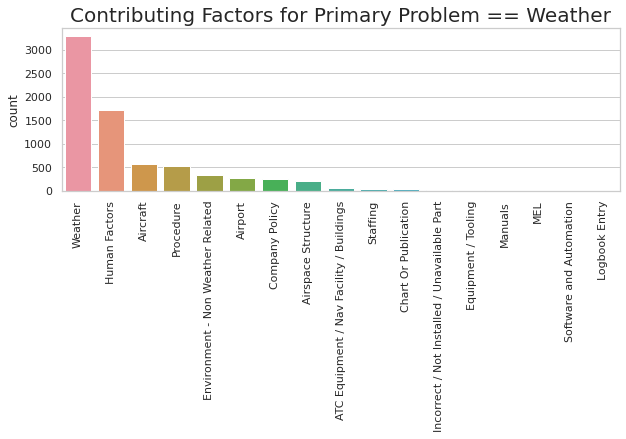

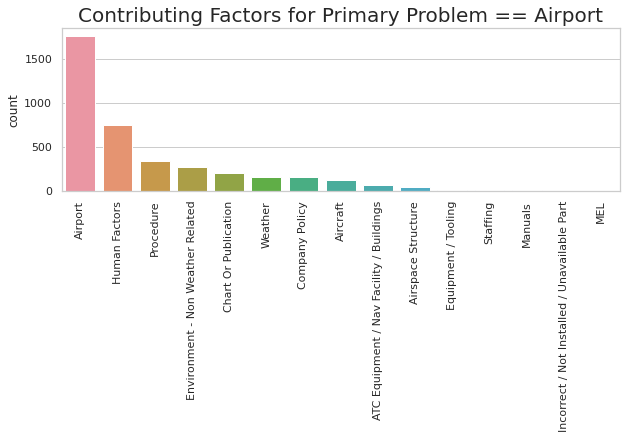

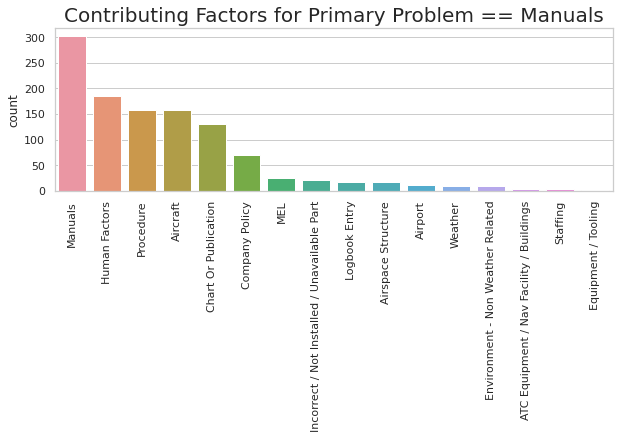

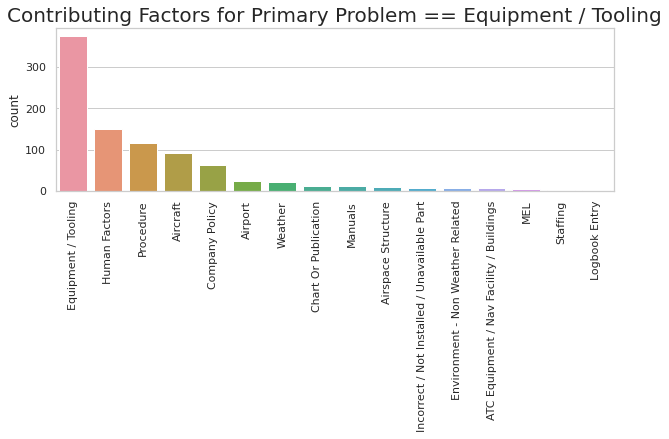

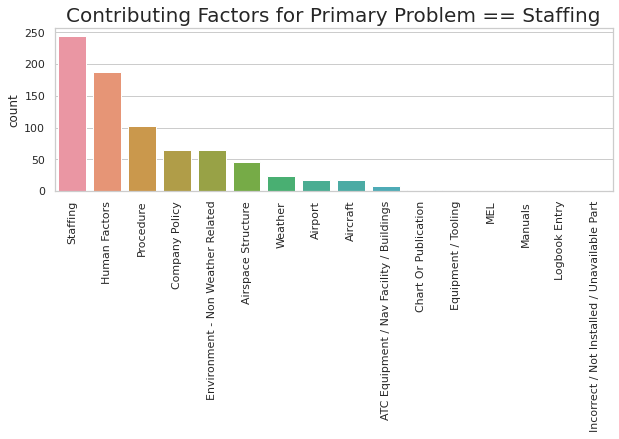

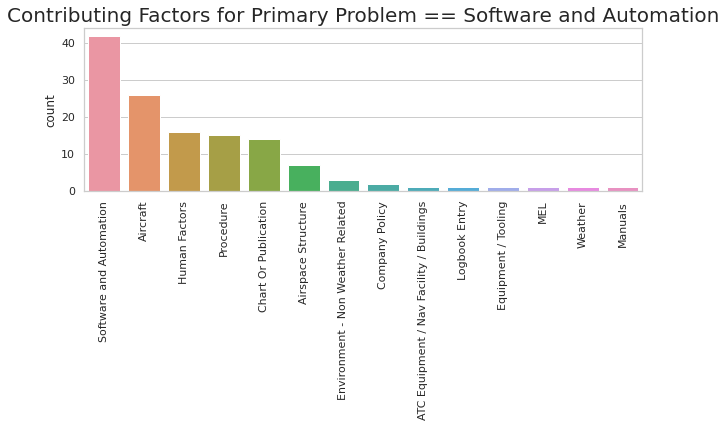

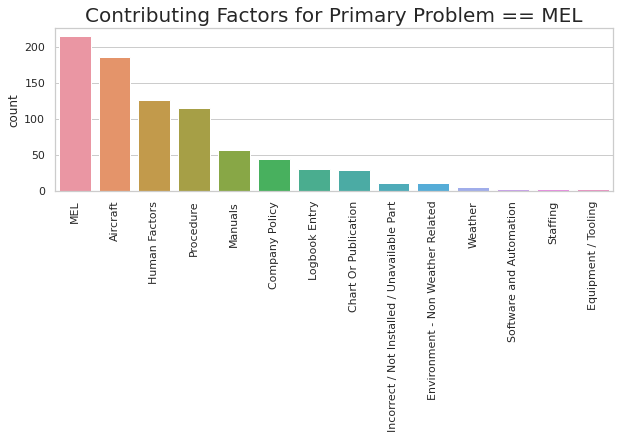

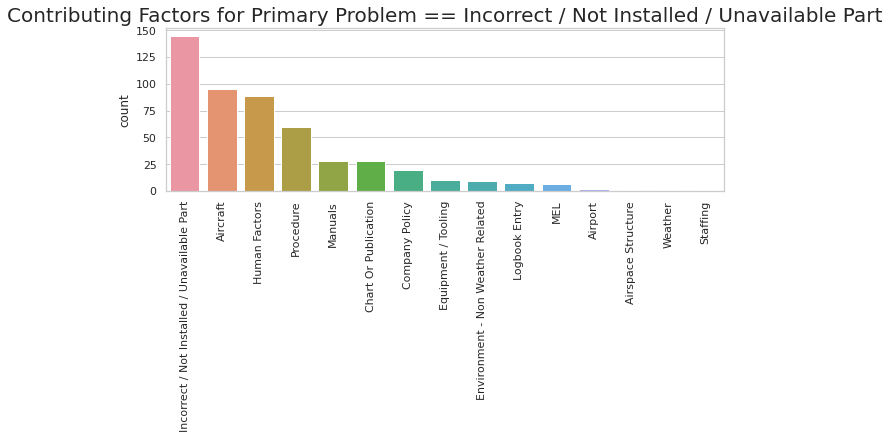

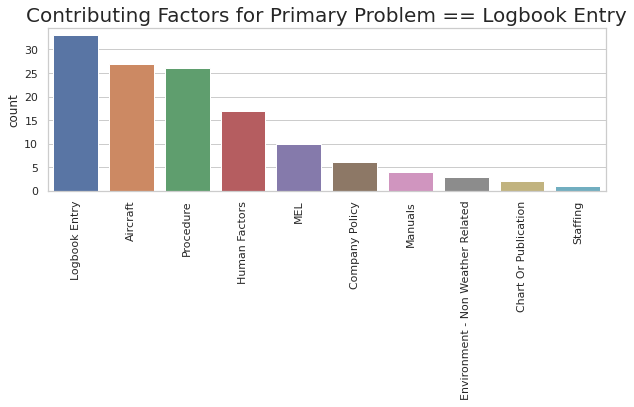

In [ ]:
#plt.rcParams.update({'figure.max_open_warning': 0});

for problem in prim_probs:
    
    # Select the data corresponding to a particular Primary Problem
    df_prob = df[df['Primary Problem'] == problem]
    
    print("\nThere are", len(df_prob), "issues with", problem, "being the Primary Problem.")
    print("Among the", len(df_prob), "issues with", problem, "being the Primary Problem, there are", 
          df_prob["Contributing Factors / Situations"].isna().sum(), "NaN's under 'Contributing Factors / Situations'.")
    
    # Make a list of all Contributing Factors for a given Primary Problem:
    cf = list()
    for contr_fact in df_prob['Contributing Factors / Situations']:
        contr_fact = str(contr_fact) # force into string format, because there was an error 'float does not have ';' separator'
        split = contr_fact.split(sep = '; ') # include a space after ';'
        cf = cf + split
        
    #print("For", problem, "the contributing factors are:", set(cf))
    
    # Countplot for the Contributing Factors
    fig = plt.figure(figsize= (10,3))
    sns.countplot(x = cf, order= pd.Series(cf).value_counts().index) # need to transform list to pd.Series for the ordering in countplot()
    plt.xticks(rotation=90)
    plt.title('Contributing Factors for Primary Problem == ' + problem, fontsize=20);

# FOCUS ON NARRATIVES

#### Examples

In [ ]:
# Set pandas settings to display full text columns
pd.options.display.max_colwidth = None

In [ ]:
df[['Narrative','Anomaly']].head(20)

Narrative  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## Narrative length

In [ ]:
# Create new column in df
df['narr_len'] = df['Narrative'].apply(lambda x: len(x))

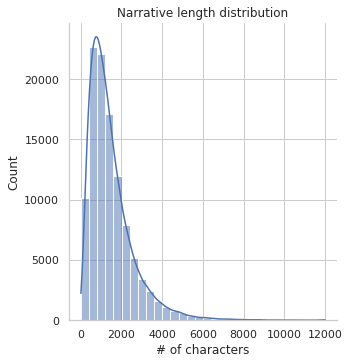

In [ ]:
# Plot
sns.displot(df['narr_len'], bins = 30, kde = True)
plt.xlabel('# of characters')
plt.title('Narrative length distribution');

### Only entries with 2 narratives

In [ ]:
# Write the database entries that contain 2 narratives, i.e. Narrative.1 is not empty
# into a separate DataFrame 
nar1_all = df[df['Narrative.1'].isna() == False]
print(f"There are {len(nar1_all)} entries where 'Narrative.1' is not empty.")

There are 14837 entries where 'Narrative.1' is not empty.


In [ ]:
# Create new column in 'nar1_all' DataFrame
# nar1_all['narr_len'] = pd.Series([len(entry) for entry in nar1_all['Narrative']])
nar1_all['narr_len'] = nar1_all['Narrative'].apply(lambda x: len(x))
# nar1_all['narr1_len'] = pd.Series([len(entry) for entry in nar1_all['Narrative.1']])
nar1_all['narr1_len'] = nar1_all['Narrative.1'].apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


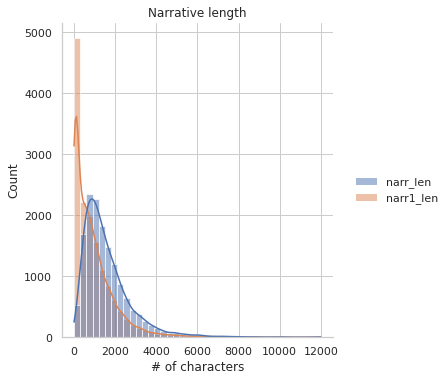

In [ ]:
# Plot
sns.displot([nar1_all['narr_len'], nar1_all['narr1_len']],
            bins = 40, kde = True)
plt.xlabel('# of characters')
plt.title('Narrative length');

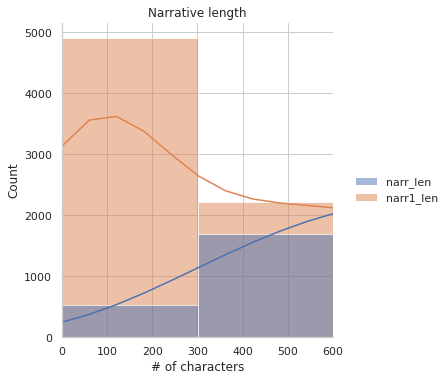

In [ ]:
# Plot (zoom)
sns.displot([nar1_all['narr_len'], nar1_all['narr1_len']],
            bins = 40, kde = True)
plt.xlabel('# of characters')
plt.title('Narrative length')
plt.xlim([0, 600]);

In [ ]:
# Examine the short 'Narrative.1' entries
# short_narr = [entry for entry in nar1_all[nar1_all['narr1_len'] < 300 ]['Narrative.1']]
short_narr = nar1_all[nar1_all['narr1_len'] < 300 ]#['Narrative.1']
short_narr[['Narrative.1','narr1_len']].head(10)

Narrative.1  \
45                                                                                                                                                                                                    [Report narrative contained no additional information.]   
64   I don't have all the details. I was working CIC/FD/CD and trying to coordinate what was exactly being closed and opened with airport at the time. The airport did not seem to know what they were going to open and close when it came to surface areas.   
107                                                                                                                                                                                                   [Report narrative contained no additional information].   
128                                                                                                      The red light / green light with MRI has been an item of concern for at least 4 years; several fixes have been attempted; and all have had failures.   
173                                                                                                                                                                                                   [Report narrative contained no additional information.]   
183                                                                              As a crew we were not sure if SLOP is/was required or an option on said route. We still don't know. We entered SLOP because it is [Company] FOM procedure on Oceanic routes.   
189                                On climbout was given 3000 feet. Lead aircraft continued climbing in accordance with departure as is usually the case. Was told to level off at 6000 feet. Lead aircraft was told that it was due to 'loss of separation'.   
211                                                                                                                                                                                                   [Report narrative contained no additional information.]   
213                                                                                                                                                                                                   [Report narrative contained no additional information.]   
221                                                                                                                                                                                                   [Report narrative contained no additional information.]   

     narr1_len  
45          55  
64         248  
107         55  
128        148  
173         55  
183        172  
189        218  
211         55  
213         55  
221         55

In [ ]:
# Count how many 'Narrative.1' contain the word 'narrative' or 'Narrative'
my_list1 = [entry for entry in nar1_all['Narrative.1'] 
            if ('Narrative' in entry or 'narrative' in entry)
            ]
len(my_list1)

3438

## WordCloud

In [ ]:
# Write all *main* narratives of the dataset into a single string 
all_nar = ''
all_nar = ' '.join(str(entry) for entry in df['Narrative'])
len(all_nar) # length in characters

160367730

In [ ]:
# Define stop word list
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) 
# we convert it to a set, more efficient (vs. a liste) for the stopword-filtering later 
# 'set' also avoids duplicates

# add additional stop words: 
stop_words.update(['.', ';', '[', ']'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


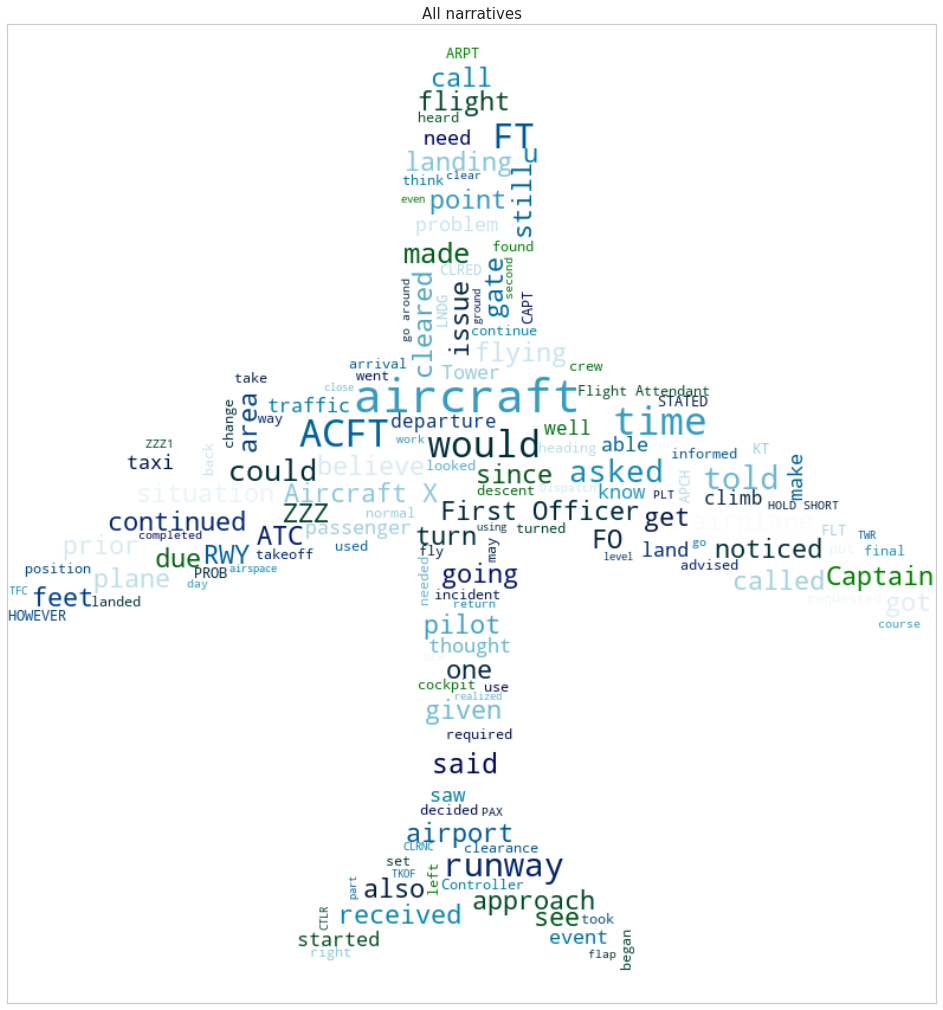

In [ ]:
fig = plt.figure(figsize = (18, 18))
plot_word_cloud(all_nar, 'All narratives', stop_words, "plane.png")

## Narratives : case style clustering

#### Defining 6 features for Case style clustering 
- Nbr of words (2+ letters)
- Starting words / Following words in  lowercase / UPPERCASE / Capital letter 

In [ ]:
def Tokenizing_KPIs(text):
    Sent_tokenizer=PunktSentenceTokenizer()
    sentences=Sent_tokenizer.tokenize(text)
    nb_sentences=len(sentences)
    
    sentence_tokens=[]
    starting_tokens_str=''
    following_tokens=[]
    for sentence in sentences:
        tokenizer = TweetTokenizer() 
        tokens = tokenizer.tokenize(sentence)
        sentence_tokens.append(tokens)
        starting_tokens_str=starting_tokens_str+' '+tokens[0]
        following_tokens.append(tokens[1:])
    following_tokens_str=''
    for i in range(len(sentences)):
        for j in range(len(following_tokens[i])):
            following_tokens_str=following_tokens_str+' '+following_tokens[i][j]
    # Starting words :
    # in UPPER CASE (2+ letters) : we don't count 1 letter words in capital : could be 'I' or a 1-letter abbrev (L R N S E W ...)
    nb_UPPERCASE_startingwords = len(re.findall(r"\b[A-Z][A-Z]+\b",  starting_tokens_str ))
    # in Capital letter (2+ letters) : we don't count 1 letter words in capital : could be 'I' or a 1-letter abbrev (L R N S E W ...)
    nb_Capital_startingwords = len(re.findall(r"\b[A-Z][a-z]+\b",  starting_tokens_str ))
    # in lower letter
    nb_lowercase_startingwords = len(re.findall(r"\b[a-z]+\b",  starting_tokens_str ))

    # Following words :
    # in UPPER CASE (2+ letters) : we don't count 1 letter words in capital : could be 'I' or a 1-letter abbrev (L R N S E W ...)
    nb_UPPERCASE_follwords = len(re.findall(r"\b[A-Z][A-Z]+\b",  following_tokens_str ))
    # in Capital letter (2+ letters) : we don't count 1 letter words in capital : could be 'I' or a 1-letter abbrev (L R N S E W ...)
    nb_Capital_follwords = len(re.findall(r"\b[A-Z][a-z]+\b",  following_tokens_str ))
    # in lower letter
    nb_lowercase_follwords = len(re.findall(r"\b[a-z]+\b",  following_tokens_str ))

    return  [nb_sentences,nb_UPPERCASE_startingwords,nb_Capital_startingwords,nb_lowercase_startingwords,nb_UPPERCASE_follwords,nb_Capital_follwords,nb_lowercase_follwords]

#### Defining Lower/Uppercase features on the whole dataset
- Following cell : approx 8 mn

In [ ]:
heure_debut = time() 

df['KPIs']=df['Narrative'].apply(lambda x: Tokenizing_KPIs(x))

heure_fin = time()
temps = heure_fin - heure_debut
print("Calculation took", temps/60, "mns")
# TAKES SEVERAL MINUTES TO RUN

Calculation took 4.460157680511474 mns


In [ ]:
columns_Case_style=['Nb Sentences',
         'nb_UPPERCASE_startingwords', 'nb_Capital_startingwords','nb_lowercase_startingwords',
         'nb_UPPERCASE_follwords','nb_Capital_follwords','nb_lowercase_follwords']
for i,col in enumerate(columns_Case_style) :
    df[col]=df['KPIs'].apply(lambda x: x[i])

df=df.drop('KPIs',axis=1)

In [ ]:
df['nb_total_startingwords']=(df['nb_UPPERCASE_startingwords']+df['nb_Capital_startingwords']+df['nb_lowercase_startingwords'])
df['nb_total_follwords']=(df['nb_UPPERCASE_follwords']+df['nb_Capital_follwords']+df['nb_lowercase_follwords'])

#### Nbr of sentences analysis

In [ ]:
df[columns_Case_style].describe().T

count        mean         std  min  25%   50%  \
Nb Sentences                108407.0   14.616584   10.269894  1.0  8.0  12.0   
nb_UPPERCASE_startingwords  108407.0    4.738753    7.416049  0.0  0.0   1.0   
nb_Capital_startingwords    108407.0    6.728274    8.262987  0.0  0.0   5.0   
nb_lowercase_startingwords  108407.0    0.115786    0.495191  0.0  0.0   0.0   
nb_UPPERCASE_follwords      108407.0   91.660751  147.256262  0.0  4.0  15.0   
nb_Capital_follwords        108407.0    6.214405   10.454960  0.0  0.0   2.0   
nb_lowercase_follwords      108407.0  143.995757  186.459874  0.0  0.0  90.0   

                              75%     max  
Nb Sentences                 19.0   148.0  
nb_UPPERCASE_startingwords    8.0   112.0  
nb_Capital_startingwords     11.0    98.0  
nb_lowercase_startingwords    0.0    20.0  
nb_UPPERCASE_follwords      136.0  2020.0  
nb_Capital_follwords          9.0   330.0  
nb_lowercase_follwords      223.0  2079.0

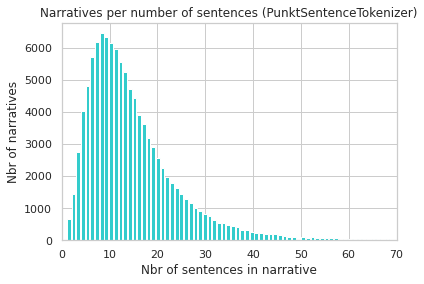

In [ ]:
plt.hist(df['Nb Sentences'],  bins = 150, rwidth=0.8,color='#33cccc')
plt.title('Narratives per number of sentences (PunktSentenceTokenizer)')
plt.xlim((0,70))
plt.xlabel('Nbr of sentences in narrative')
plt.ylabel('Nbr of narratives');


In [ ]:
#Narrative having the maximum of sentences (283): we can see that the nb of sentences is overrated due to '....'
print(max(df['Nb Sentences']))
df[df['Nb Sentences']==max(df['Nb Sentences'])]['Narrative']

148


95556    FO FLYING. ON ROTATION AND LIFTOFF WITH A POSITIVE RATE FO CALLED FOR GEAR UP. AS I REACHED FOR THE GEAR LEVER MY PFD; ND AND UPPER ECAM WENT BLANK. BROUGHT GEAR HANDLE UP; BUT COULD TELL GEAR DID NOT COME UP. NO AUDIO WARNINGS GOING OFF DUE TO INHIBITS. STATED THAT I HAD AN ELECTRICAL FAILURE TO FO AND FOR HIM TO KEEP FLYING. I LOOKED TO HIS PFD AND ND AND HIS WAS STILL WORKING. ALSO NOTICED THAT HE HAD THE MESSAGE 'USE MANUAL PITCH TRIM' ON HIS PFD. SAID TO HIM THAT HE WAS IN DIRECT LAW AND WOULD HAVE TO TRIM MANUALLY. WE DECIDED TO CONTINUE ON THE HEADING ASSIGNED BY TWR ON TKOF AND CLIMB TO OUR FIRST CLRED ALTITUDE WHILE CLEANING UP THE ACFT. AS WE LEVELED AT 2500 FT MSL I SAID TO FO THAT HE WOULD NEED TO USE MANUAL THROTTLES; WHICH HE DID. WE LEVELED AT 2500 FT MSL. AS WE WERE CLEANING UP I WAS WATCHING THE ECAM'S ON THE LOWER ECAM. THEY WERE DANCING. ONE WOULD COME UP THEN MOVE OR GO AWAY AND ANOTHER ONE APPEAR. AS WE LEVELED OFF; ONE ECAM PROC STAYED ON TOP SO I DID IT.

In [ ]:
print('# narratives with nb_total_startingwords=0 : ',sum(df['nb_total_startingwords']==0))
print('# narratives with nb_total_follwords=0 : ',sum(df['nb_total_follwords']==0))

# narratives with nb_total_startingwords=0 :  275
# narratives with nb_total_follwords=0 :  0


In [ ]:
df['pct_UPPERCASE_startingwords']=df['nb_UPPERCASE_startingwords']/df['nb_total_startingwords']
df['pct_Capital_startingwords']=df['nb_Capital_startingwords']/df['nb_total_startingwords']
df['pct_lowercase_startingwords']=df['nb_lowercase_startingwords']/df['nb_total_startingwords']

df['pct_UPPERCASE_startingwords']=df['pct_UPPERCASE_startingwords'].fillna(0)
df['pct_Capital_startingwords']=df['pct_Capital_startingwords'].fillna(0)
df['pct_lowercase_startingwords']=df['pct_lowercase_startingwords'].fillna(0)

df['pct_UPPERCASE_follwords']=df['nb_UPPERCASE_follwords']/df['nb_total_follwords']
df['pct_Capital_follwords']=df['nb_Capital_follwords']/df['nb_total_follwords']
df['pct_lowercase_follwords']=df['nb_lowercase_follwords']/df['nb_total_follwords']

In [ ]:
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restaure pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

In [ ]:
columns_Case_style2=['Narrative','Nb Sentences','nb_UPPERCASE_startingwords', 'nb_Capital_startingwords','nb_lowercase_startingwords', 'nb_UPPERCASE_follwords','nb_Capital_follwords','nb_lowercase_follwords','nb_total_startingwords','nb_total_follwords','pct_UPPERCASE_startingwords','pct_Capital_startingwords','pct_lowercase_startingwords','pct_UPPERCASE_follwords','pct_Capital_follwords','pct_lowercase_follwords']

df[columns_Case_style2].head()

Narrative  Nb Sentences  \
0  A BE20 was inbound to ANC via YESKA. He was to...            17   
1  A C208 departed for Kenai. Kenai Tower called ...            18   
2  Descending into FAI. Cleared for Visual Approa...            14   
3  I had just assumed control of Sector 9. A C130...            32   
4  During approach to Runway 23; we received a ru...            21   

   nb_UPPERCASE_startingwords  nb_Capital_startingwords  \
0                           0                        11   
1                           0                        11   
2                           0                        11   
3                           1                        22   
4                           0                        21   

   nb_lowercase_startingwords  nb_UPPERCASE_follwords  nb_Capital_follwords  \
0                           0                       7                     1   
1                           0                       4                    20   
2                           0                       8                    13   
3                           0                      53                    23   
4                           0                      10                    14   

   nb_lowercase_follwords  nb_total_startingwords  nb_total_follwords  \
0                     162                      11                 170   
1                     311                      11                 335   
2                     141                      11                 162   
3                     446                      23                 522   
4                     485                      21                 509   

   pct_UPPERCASE_startingwords  pct_Capital_startingwords  \
0                     0.000000                   1.000000   
1                     0.000000                   1.000000   
2                     0.000000                   1.000000   
3                     0.043478                   0.956522   
4                     0.000000                   1.000000   

   pct_lowercase_startingwords  pct_UPPERCASE_follwords  \
0                          0.0                 0.041176   
1                          0.0                 0.011940   
2                          0.0                 0.049383   
3                          0.0                 0.101533   
4                          0.0                 0.019646   

   pct_Capital_follwords  pct_lowercase_follwords  
0               0.005882                 0.952941  
1               0.059701                 0.928358  
2               0.080247                 0.870370  
3               0.044061                 0.854406  
4               0.027505                 0.952849

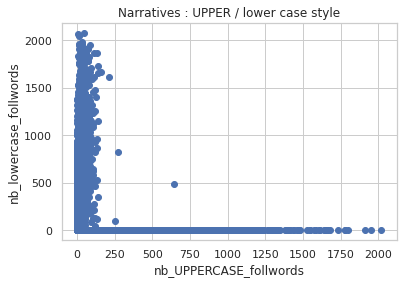

In [ ]:
plt.scatter(df['nb_UPPERCASE_follwords'], df['nb_lowercase_follwords'])
plt.title('Narratives : UPPER / lower case style')
plt.xlabel('nb_UPPERCASE_follwords')
plt.ylabel('nb_lowercase_follwords');


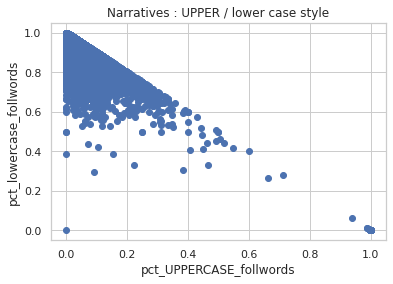

In [ ]:
plt.scatter(df['pct_UPPERCASE_follwords'], df['pct_lowercase_follwords'])
plt.title('Narratives : UPPER / lower case style')
plt.xlabel('pct_UPPERCASE_follwords')
plt.ylabel('pct_lowercase_follwords');

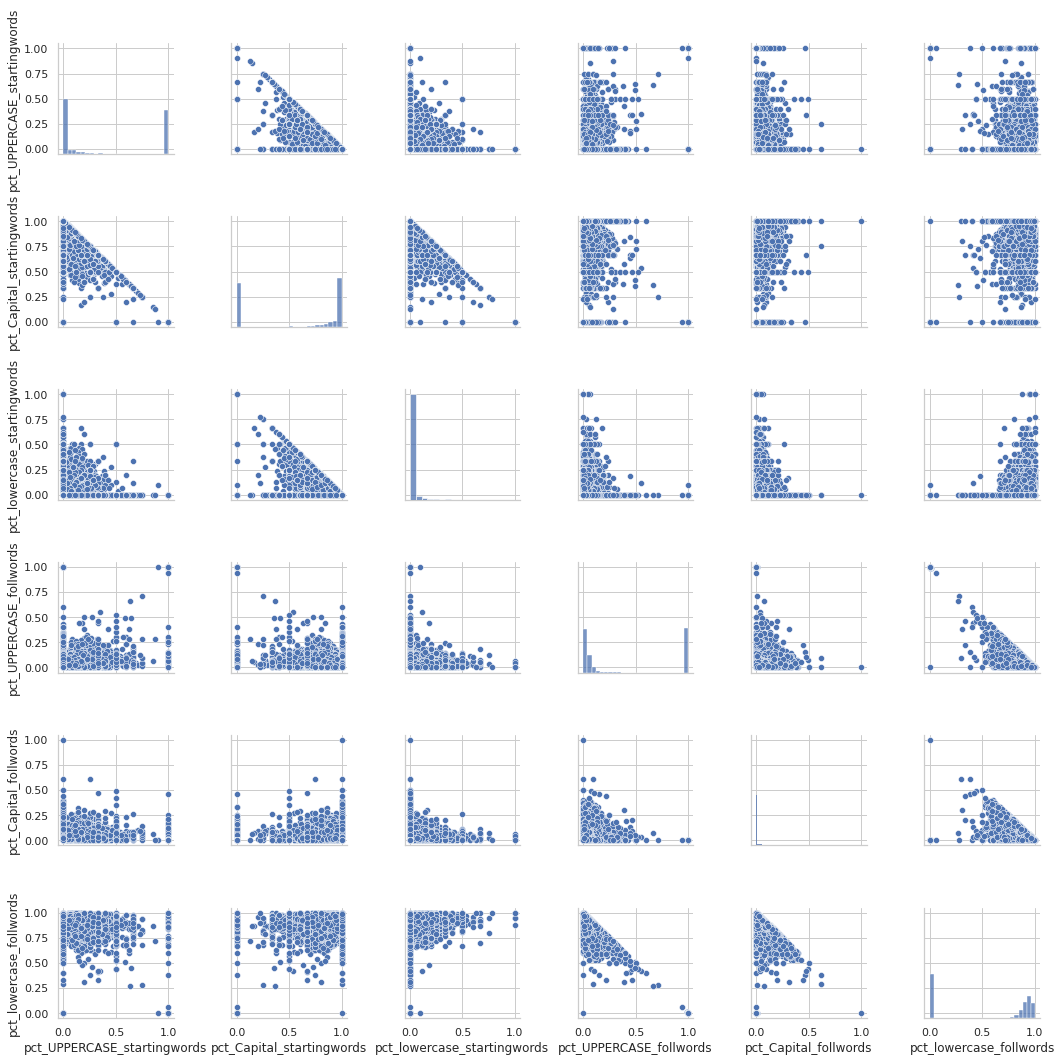

In [ ]:
# Discovery of likns between clustering features
#
sns.pairplot(df[['pct_UPPERCASE_startingwords', 'pct_Capital_startingwords','pct_lowercase_startingwords', 'pct_UPPERCASE_follwords','pct_Capital_follwords','pct_lowercase_follwords']]);

In [ ]:
ls_features= ['pct_UPPERCASE_startingwords', 'pct_Capital_startingwords','pct_lowercase_startingwords', 'pct_UPPERCASE_follwords','pct_Capital_follwords','pct_lowercase_follwords']
data_classif=df[ls_features]

In [ ]:
data_classif.describe().T

count      mean       std  min       25%  \
pct_UPPERCASE_startingwords  108407.0  0.409564  0.477629  0.0  0.000000   
pct_Capital_startingwords    108407.0  0.579197  0.472669  0.0  0.000000   
pct_lowercase_startingwords  108407.0  0.008703  0.038148  0.0  0.000000   
pct_UPPERCASE_follwords      108407.0  0.416315  0.471089  0.0  0.022727   
pct_Capital_follwords        108407.0  0.025281  0.035770  0.0  0.000000   
pct_lowercase_follwords      108407.0  0.558404  0.451855  0.0  0.000000   

                                  50%       75%  max  
pct_UPPERCASE_startingwords  0.058824  1.000000  1.0  
pct_Capital_startingwords    0.900000  1.000000  1.0  
pct_lowercase_startingwords  0.000000  0.000000  1.0  
pct_UPPERCASE_follwords      0.063694  1.000000  1.0  
pct_Capital_follwords        0.010638  0.040146  1.0  
pct_lowercase_follwords      0.878788  0.939799  1.0

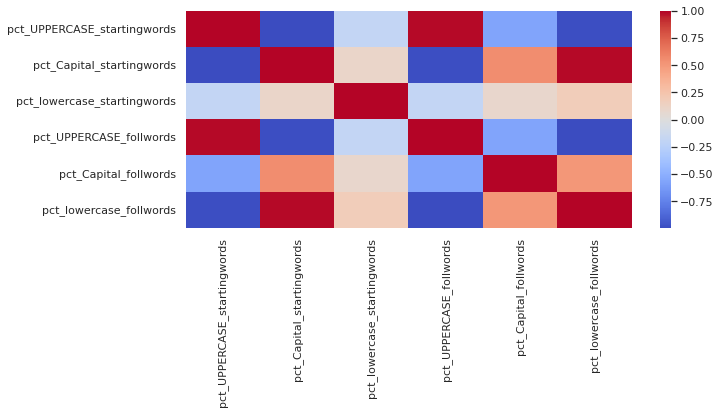

In [ ]:
sns.set(rc={'figure.figsize':(10,4)})
df_corr = data_classif.corr()
ax = sns.heatmap(df_corr, xticklabels = df_corr.columns , 
                 yticklabels = df_corr.columns, cmap = 'coolwarm')


### Clustering

In [ ]:
heure_debut = time() 


# Définition de la liste de n_clusters
range_n_clusters = [2, 3, 4, 5, 6]
#range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Initialisation de la liste pour graphique
distorsions = []

for k in range_n_clusters:
    # Algorithme de K-means
    cluster = KMeans(n_clusters = k,random_state=123)
    cluster.fit(data_classif)
    # Centroids and labels
    centroids = cluster.cluster_centers_
    # cdist calcule la distance de chaque point du df à chaque centroide = un vecteur de dimension k 
    # => on prend le min = la distance au centroide le plus proche
    distorsions.append(sum(np.min(cdist(data_classif, cluster.cluster_centers_, 'euclidean'),axis=1))/len(data_classif))


heure_fin = time()
temps = heure_fin - heure_debut
print("Calculation took", temps/60, "mns")


Calculation took 0.11162867943445841 mns


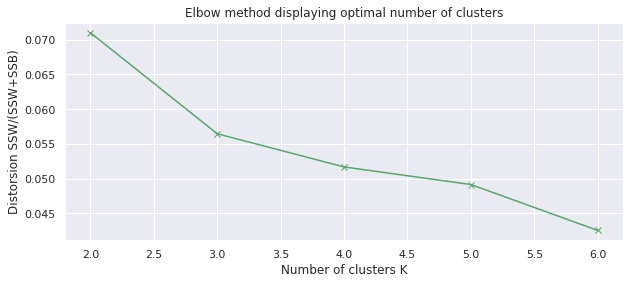

In [ ]:
plt.plot(range_n_clusters,distorsions,'gx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Distorsion SSW/(SSW+SSB)')
plt.title('Elbow method displaying optimal number of clusters')  # 3 clusters
plt.show()


In [ ]:
# Algorithme de K-means  
nb_clusters=3
kmeans=KMeans(n_clusters=nb_clusters, random_state=123)
kmeans.fit(data_classif)

# Centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)
print(labels)


[[9.96155973e-01 2.27444644e-05 2.34290802e-06 9.99830080e-01
  2.72537645e-05 1.42665930e-04]
 [8.25627605e-03 9.84354879e-01 7.38884543e-03 3.45415161e-02
  4.13810251e-02 9.24077459e-01]
 [1.60848830e-01 7.66838025e-01 5.95496127e-02 5.57948249e-02
  4.36209685e-02 9.00584207e-01]]
[1 1 1 ... 0 0 0]


In [ ]:
df_labels=pd.DataFrame(labels).rename(columns={0:'Style Cluster'})
# Fusion avec notre dataset de Kmeans
data_classif=pd.concat( [data_classif ,df_labels] ,  axis = 1)
data_classif['Style Cluster']=data_classif['Style Cluster'].astype('str')


In [ ]:
# Fusion of Clusters with our dataframe 
df=pd.concat( [df ,df_labels] ,  axis = 1)
df['Style Cluster']=df['Style Cluster'].astype('str')

In [ ]:
data_classif['Style Cluster'].value_counts()

1    56956
0    42682
2     8769
Name: Style Cluster, dtype: int64

<Figure size 432x432 with 0 Axes>

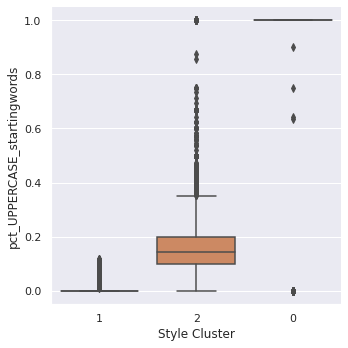

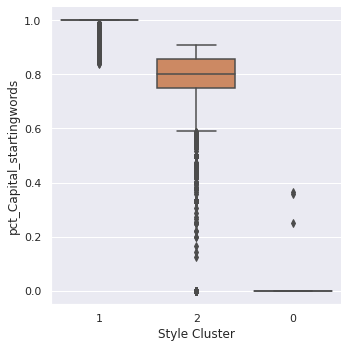

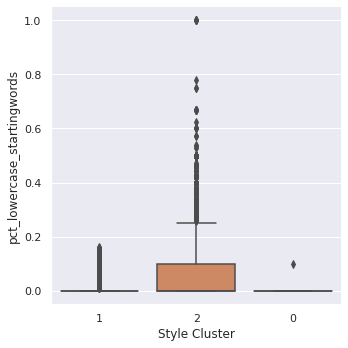

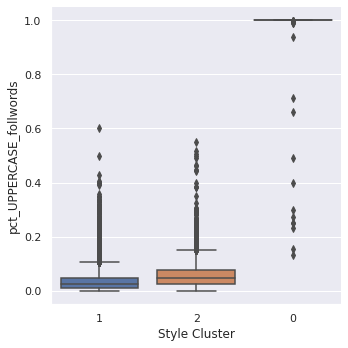

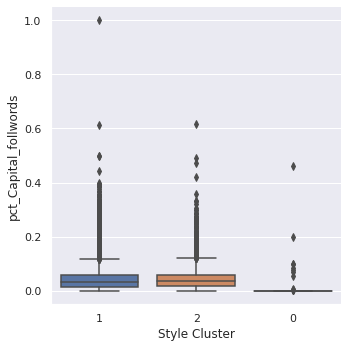

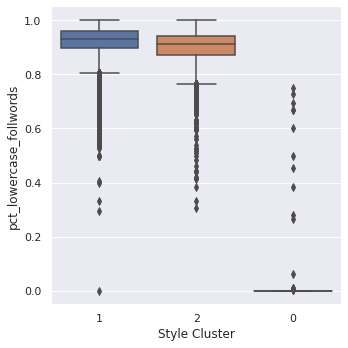

In [ ]:
# ANALYSIS BY FEATURE
# For each feature : boxplot of the feature by cluster
fig = plt.figure(figsize=(6,6))
for i, feature in enumerate(ls_features) :
    sns.catplot(data=data_classif,x='Style Cluster',y=feature,kind ='box' );


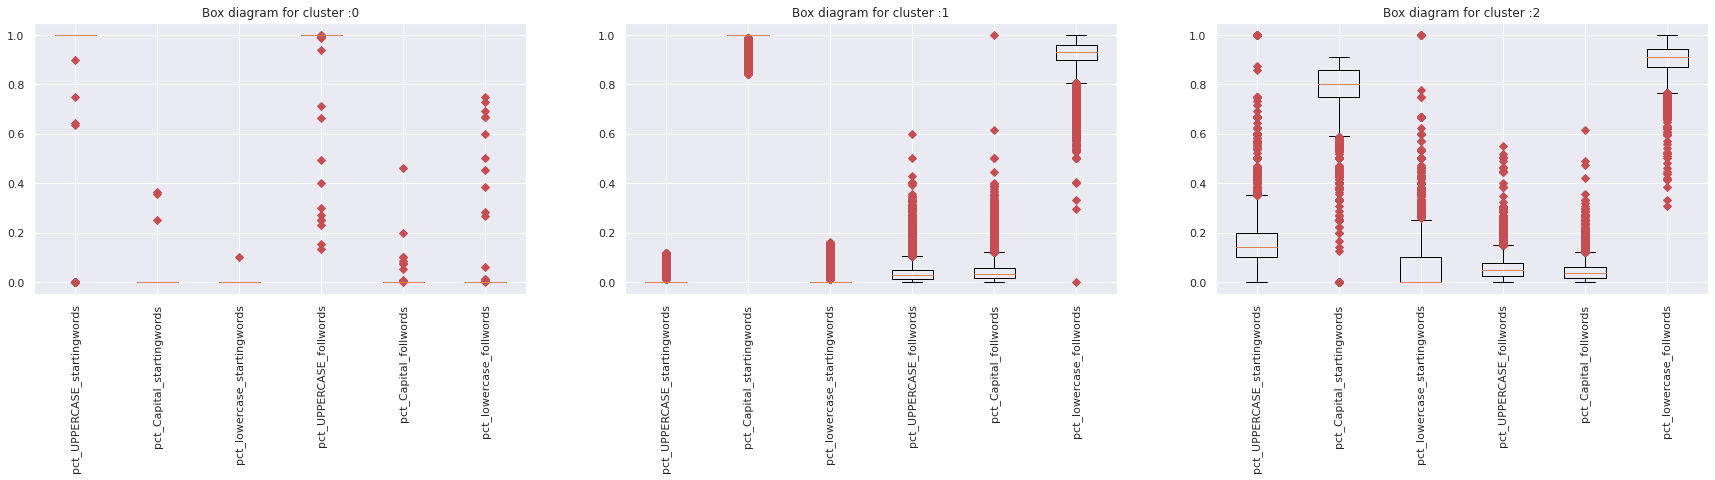

In [ ]:
# ANALYSIS BY CLUSTER
# For each cluster : boxplot of all the clustering features in the df filtered by the cluster
plt.figure(figsize=(30, 5))
for clust in range(0,3) :
    plt.subplot(1,3,clust+1)
    df_plot=data_classif[data_classif['Style Cluster']==str(clust)]
    plt.title('Box diagram for cluster :'+str(clust))
    plt.boxplot(df_plot[ls_features].values, 0, 'rD', labels = ls_features)
    plt.xticks(rotation=90)
plt.show()


In [ ]:
# Exzmples of short narratives in a cluster (ie cluster 2)
# Set pandas settings to display full text columns
pd.options.display.max_colwidth = None
df[(df['Style Cluster']=='2')&(df['Nb Sentences']<=6)]['Narrative'].head(20)

20                                                                                                                                                                                                                                                                                                                                                                                                                                               AMR Tower cleared our aircraft for left 45 degree entry for left traffic Runway 25. Upon entry into the traffic pattern; upwind traffic for Runway 25 turned early left crossswind. This action resulted in a traffic conflict causing both pilots to take immediate action to avoid a traffic conflict. Had the aircraft not turned an early crosswind; spacing would not have been an issue.
49                                                                                                                                                                                      

In [ ]:
# Restaure pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108407 entries, 0 to 108406
Columns: 145 entries, Date to Style Cluster
dtypes: bool(1), float64(28), int64(12), object(104)
memory usage: 124.1+ MB


In [ ]:
# Labeling the clusters according to the analysis of boxplots : random_state in KMeans allows us to fix the correspondance
df['Style Cluster_lbl']=df['Style Cluster'].replace(to_replace=['0','1','2'], value=['upper','lower','mix'])

In [ ]:
df['Style Cluster_lbl'].value_counts()

lower    56956
upper    42682
mix       8769
Name: Style Cluster_lbl, dtype: int64

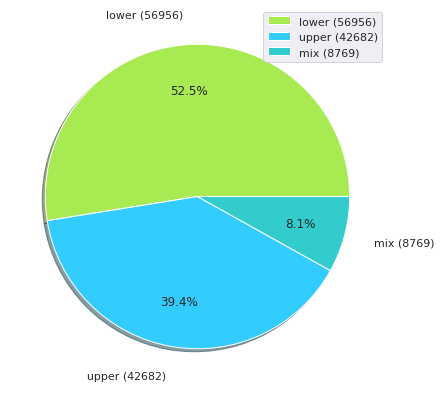

In [ ]:
# Distribution of clusters
df_plot=pd.DataFrame(df['Style Cluster_lbl'].value_counts())

df_plot['index_vol']=df_plot.index.astype(str) + ' (' +df_plot['Style Cluster_lbl'].astype(str)+ ')'

df_plot
plt.figure( figsize= (7, 7) )
plt.pie(df_plot['Style Cluster_lbl']
        , labels = df_plot.index_vol
        ,colors=['#a7ea52', '#33ccff', '#33cccc']
        ,labeldistance =1.2  
        #,explode=[0, 0,0, 0.2, 0, 0]
     ,autopct = lambda x: str(round(x, 1)) + '%'
        ,pctdistance=0.7
        ,shadow =True )
plt.legend();       


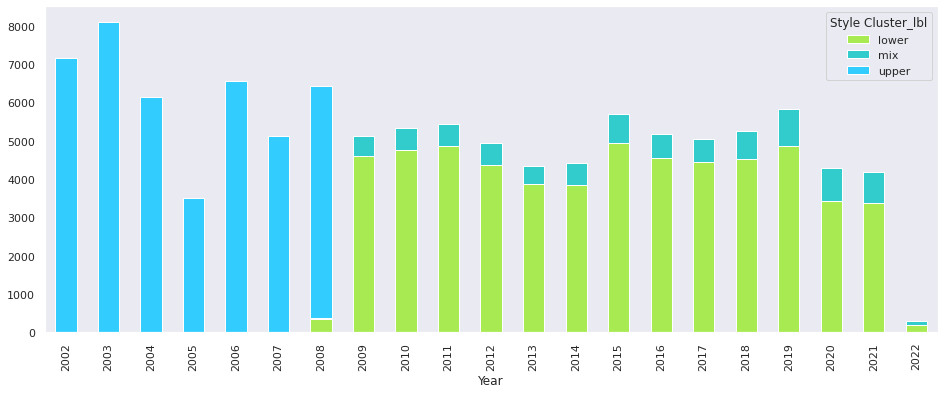

In [ ]:
# Distribution of clusters through the years : after 2008 , no more narratives in uppercase !!!
df_plot = df.groupby(['Year','Style Cluster_lbl']).size().reset_index().pivot(columns='Style Cluster_lbl', index='Year', values=0)
fig, ax = plt.subplots(figsize=(16,6))
df_plot.plot(kind='bar', color=['#a7ea52', '#33cccc', '#33ccff'], stacked=True,ax=ax)
plt.grid(False);


## Abbreviations

### Looking for Narratives with both forms (Abbreviations and Full-text) of the same word/expression

In [ ]:
# Set pandas settings to display full text columns
pd.options.display.max_colwidth = None

#### Example 1 : aircraft / ACFT  
We voluntary chose an abbreviation which can't be contained in a common word , as we are currently using 'in' and not Regex to find the abbreviation in the Narrative (i.e. air carrier / ACR wouldn't be a good example as ACR could be contained in 'acrobaty' for instance)

In [ ]:
df['Narrative_aircraft']=df['Narrative'].apply(lambda x: 1 if ('aircraft' in x.lower()) else 0)
df['Narrative_ACFT']=df['Narrative'].apply(lambda x: 1 if ('ACFT' in x.upper()) else 0)
df['Narrative_aircraft/ACFT']=df['Narrative'].apply(lambda x: 1 if (('aircraft' in x.lower()) or ('ACFT' in x.upper()) )else 0)

In [ ]:
df[df['Narrative_aircraft']==1]['Narrative'].head(10)
# All narratives in head appears to be written in lower case letters  => to be checked

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
df[df['Narrative_ACFT']==1]['Narrative'].head(10)
# All narratives in head appears to be written mostly in upper case letters   => to be checked

316                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
pd.crosstab(df['Narrative_aircraft'],df['Narrative_ACFT'])

Narrative_ACFT          0      1
Narrative_aircraft              
0                   38506  26225
1                   43503    173

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_ACFT'])

Narrative_ACFT         0      1
Style Cluster_lbl              
lower              56929     27
mix                 8756     13
upper              16324  26358

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_aircraft'])

Narrative_aircraft      0      1
Style Cluster_lbl               
lower               19109  37847
mix                  3364   5405
upper               42258    424

#### Example 2 : air traffic control / ATC

We voluntary chose an abbreviation which can't be contained in a common word , as we are currently using 'in' and not Regex to find the abbreviation in the Narrative (i.e. air carrier / ACR wouldn't be a good example as ACR could be contained in 'acrobaty' for instance)

In [ ]:
df['Narrative_air_traffic_control']=df['Narrative'].apply(lambda x: 1 if ('air traffic control' in x.lower()) else 0)
df['Narrative_ATC']=df['Narrative'].apply(lambda x: 1 if ('ATC' in x.upper()) else 0)

In [ ]:
df[df['Narrative_air_traffic_control']==1]['Narrative'].head(10)
# All narratives in head appears to be written in lower case letters  => to be checked

55                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
df[df['Narrative_ATC']==1]['Narrative'].head(10)
# All narratives in head appears to be written mostly in upper case letters   => to be checked

3     I had just assumed control of Sector 9. A C130 was on the ILS/D Z Runway 25 approach at ADQ. A Dash 8 had been issued holding at CHINI at 6;000 FT. The Dash 8 reported in the hold at CHINI. The C130 reported on the missed approach and a request to hold at CHINI. I asked the C130 if he wanted a higher altitude or to hold at 3;000 FT. He reported 3;700 FT and would like to hold at 4;000 FT. I issued 4;000 FT and an EFC. At the time I didn't know if the C130 flew the wrong missed approach; or was actually cleared for the ILS/D-Y Runway 25 approach and was flying the correct missed approach. The Dash 8 requested lower and was issued 5;000 FT. The Dash 8 and the C130 discussed how long they were able to hold before returning to ANC; and the C130 indicated that he would like to accommodate the Dash 8 and let them attempt an approach first. By this time the C130 was already to CHINI. I elected to clear him to proceed eastbound rather than north to be clear of the Dash 8. I started to cl

In [ ]:
pd.crosstab(df['Narrative_air_traffic_control'],df['Narrative_ATC'])

Narrative_ATC                      0      1
Narrative_air_traffic_control              
0                              65981  41900
1                                205    321

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_ATC'])

Narrative_ATC          0      1
Style Cluster_lbl              
lower              34386  22570
mix                 3946   4823
upper              27854  14828

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_air_traffic_control'])

Narrative_air_traffic_control      0    1
Style Cluster_lbl                        
lower                          56506  450
mix                             8696   73
upper                          42679    3

#### Example 3 : as soon as possible / ASAP

We voluntary chose an abbreviation which can't be contained in a common word , as we are currently using 'in' and not Regex to find the abbreviation in the Narrative 
In this example, we assumed that the abbreviation (wich is usual langage) would be more used than the full text expression . It is finally not the case (~600 for full text vs ~1000 for abbrev) 

In [ ]:
df['Narrative_as_soon_as_possible']=df['Narrative'].apply(lambda x: 1 if ('as soon as possible' in x.lower()) else 0)
df['Narrative_ASAP']=df['Narrative'].apply(lambda x: 1 if ('ASAP' in x.upper()) else 0)

In [ ]:
pd.crosstab(df['Narrative_as_soon_as_possible'],df['Narrative_ASAP'])

Narrative_ASAP                      0     1
Narrative_as_soon_as_possible              
0                              106756  1026
1                                 604    21

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_ASAP'])

Narrative_ASAP         0    1
Style Cluster_lbl            
lower              56467  489
mix                 8699   70
upper              42194  488

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_as_soon_as_possible'])

Narrative_as_soon_as_possible      0    1
Style Cluster_lbl                        
lower                          56484  472
mix                             8714   55
upper                          42584   98

In [ ]:
# Restaure pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

In [ ]:
df['Narrative_;000']=df['Narrative'].apply(lambda x: 1 if (';000' in x.lower()) else 0)
pd.crosstab(df['Narrative_;000'],df['Narrative_as_soon_as_possible'])

Narrative_as_soon_as_possible      0    1
Narrative_;000                           
0                              92126  452
1                              15656  173

In [ ]:
# Set pandas settings to display full text columns
pd.options.display.max_colwidth = None
df[df['Narrative_;000']==1]['Narrative'].head(10)
# All narratives in head appears to be written in lower case letters  => to be checked

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
df.columns


Index(['Date', 'Local Time Of Day', 'Locale Reference', 'State Reference',
       'Relative Position.Angle.Radial',
       'Relative Position.Distance.Nautical Miles',
       'Altitude.AGL.Single Value', 'Altitude.MSL.Single Value',
       'Latitude / Longitude (UAS)', 'Flight Conditions',
       ...
       'Style Cluster', 'Style Cluster_lbl', 'Narrative_aircraft',
       'Narrative_ACFT', 'Narrative_aircraft/ACFT',
       'Narrative_air_traffic_control', 'Narrative_ATC',
       'Narrative_as_soon_as_possible', 'Narrative_ASAP', 'Narrative_;000'],
      dtype='object', length=154)

In [ ]:
# Cleaning of intermediate features
df=df.drop(['Narrative_aircraft',
       'Narrative_ACFT', 'Narrative_aircraft/ACFT',
       'Narrative_air_traffic_control', 'Narrative_ATC',
       'Narrative_as_soon_as_possible', 'Narrative_ASAP', 'Narrative_;000'],axis=1)

# DEALING WITH ABBREVIATIONS FOR NARRATIVE PREPROCESSING

### Finding full-text forms of expression : looking for specific cases to deal with

#### Pandas settings : to display full text columns

In [ ]:
### Display full columnwidth :  Set pandas settings to display full text columns
pd.options.display.max_colwidth = None

#### ACARS / Automatic Communications Addressing & Reporting System
- abbreviation used in 3518 occurences  (naive approach)
- exists only in 1 narrative (2 occurences) with "and" instead of "&" 
- we replace the full-text by "Automatic Communications Addressing and Reporting System"

In [ ]:
cols=[]
col='Narrative_ACARS'
cols.append(col)
text='acars'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " acars ":  4009


In [ ]:
col='Narrative_ACARS_FT'
cols.append(col)
text='automatic communications addressing'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " automatic communications addressing ":  3


In [ ]:
df[df[col]==1]['Narrative'].head(2)

16871                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            We were preparing to operate Flight X f

In [ ]:
df=df.drop(cols,axis=1)

#### AFD / Airport/Facility Directory
- AFD acronyms exists under 2 forms  (naive approach) : AFD (171 narratives) and A/FD (22 narratives) : replace "A/FD" by "AFD"
- Full text exists in the form : 
    - "airport/facility directory" : 9 occurences (0 in plural)
    - "airport facility directory" : 22 occurences
    - "airport facility directories" : 2 occurences

In [ ]:
cols=[]
col='Narrative_AFD'
cols.append(col)
text='afd'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " afd ":  182


In [ ]:
col='Narrative_AFD_/'
cols.append(col)
text='a/fd'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " a/fd ":  24


In [ ]:
col='Narrative_AFD_FT_1'
cols.append(col)
text='airport/facility directory'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
df[df[col]==1]['Narrative'].head(2)

Nb of occurrences " airport/facility directory ":  9


411     I taxied an amphibious aircraft into the water at the museum ramp at Lake Hood airport (LHD) and taxied west along the shoreline in what I believed was an uncontrolled area before contacting the Tower. This is the procedure for most parts of the lake. When I advised the Tower that I was taxiing for departure from the museum ramp; the Tower told me to hold short of the west water lane. As I was taxiing parallel to the water lane in an area I believed to be clear of it; I replied that I would remain clear of the water lane. Tower repeated that they needed me to hold short of the water lane; so I read back that I was holding short of it. They asked me to call the Tower and informed me that when I had entered the water from the museum ramp; I had entered the area that was considered part of the water lane; and therefore I had taxied onto an active water lane without a clearance. I was told I should have requested a clearance before entering the water. My reason for believing that I

In [ ]:
col='Narrative_AFD_FT_1s'
cols.append(col)
text='airport/facility directories'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " airport/facility directories ":  0


In [ ]:
col='Narrative_AFD_FT_2'
cols.append(col)
text='airport facility directory'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
df[df[col]==1]['Narrative'].head(2)

Nb of occurrences " airport facility directory ":  27


1015                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [ ]:
col='Narrative_AFD_FT_2s'
cols.append(col)
text='airport facility directories'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

df[df[col]==1]['Narrative'].head(2)

Nb of occurrences " airport facility directories ":  2


21022    At LNA helicopters perform right traffic for all runways; while fixed wing traffic performs left traffic for all runways. After turning into a 1000 ft downwind and reporting position I observed a fixed wing aircraft passing close below us and just barely behind our track. I alerted my student to the traffic and we amended our path to the right in order to maximize clearance. It is unfortunately not uncommon for aircraft to enter left crosswind legs 'from the right' at LNA and I am keenly aware of the danger this poses. This aircraft however was not performing any standard pattern entry. I instructed my student to extend our downwind and amend the plan to perform a straight in autorotation instead of the 180 degree autorotation we had originally intended. As is my habit when I fail to hear any radio calls from an aircraft in the pattern I performed a comm check; to which another helicopter on field at the time confirmed we were loud and clear. We continued to observe the airpla

In [ ]:
df=df.drop(cols,axis=1)

#### ALSF / Standard 2400' Hi-Intensity Approach Lighting System With Sequenced Flashers 
-  Full text exists in only 1 occurrence, where the acronym is also present

In [ ]:
cols=[]
col='Narrative_ALSF_FT'
cols.append(col)
text='intensity approach lighting system'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
df[df[col]==1]['Narrative'].head(2)

Nb of occurrences " intensity approach lighting system ":  1


43236    Ice fog conditions. BNA was variable in and out of CAT II/III conditions. We were running CAT II/III operations to RWY 2L/2R. RWY 2L approach lights have been a maintenance issue for months. The following was copied verbatim off the IDS [Information Display System]. 'RWY 02L FLASHERS NOT AVAIL ON STEP 1; USE 2 AND ABOVE.' 'RWY 02L APCH LGHTS FAILURE ALL STEPS SSALR (Simplified Short Approach Lighting System with Runway Alignment Indicator Lights) MODE BUT WORK. USE ALSF (High Intensity Approach Lighting System with Sequenced Flashing Lights) WILL SILENCE FAILURE.'I was working CIC (Controller In Charge). Right after I took over the position I noticed that the 02L approach lights had an illuminated caution light. Lights were set at level 4 with flashers and ALSAF. I informed the CIC downstairs that CAT II/III was not available for that runway due to the caution and we needed to get an AF (Airway Facilities) light check because I didn't think the lights were monitored correctly/

In [ ]:
df=df.drop(cols,axis=1)

#### AWOS / Automatic Weather Observing/Reporting System
- abbreviation is used in 475 occurences  (naive approach)
-   exists only in 1 occurence in the following full-text form "automatic weather reporting station"

In [ ]:
cols=[]
col='Narrative_AWOS'
cols.append(col)
text='awos'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " awos ":  555


In [ ]:
col='Narrative_AWOS_FT'
cols.append(col)
text='automatic weather observing'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " automatic weather observing ":  0


In [ ]:
col='Narrative_AWOS_FT2'
cols.append(col)
text='automatic weather reporting'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

df[df[col]==1]['Narrative'].head(2)
# exists only under the form "automatic weather reporting station"

Nb of occurrences " automatic weather reporting ":  1


66247    I was flying a J3 Cub to ZZZ. I'm a new sport pilot having only gotten my license about two weeks ago. I got caught up with finding the airport; making frequency changes; getting the winds from the automatic weather reporting station; and trying to figure out how I should enter the pattern. I was not scanning outside the aircraft because I was too focused on everything inside the aircraft. I did not see an aircraft; or hear it on CTAF because I was listening to the weather; departing a runway that I was crossing the extended centerline of. I was around 2 miles away. I finally saw the aircraft as it was coming up on my right side. We both turned left and it was fine; but it scared me quite a bit. After that scare; I just turned away from the airport and left while scanning for other aircraft. Things that I think contributed to this near miss are:-I did not plan the cross country because it was short and I figured I could figure it out on the fly by getting frequencies from my s

In [ ]:
df=df.drop(cols,axis=1)

#### CTAF / Common Traffic Advisory Frequency
- abbreviation is used in 1715 occurences  (naive approach)
-   exists only in 16 occurences in full text. 
- 0 occurence in full-text plural

In [ ]:
cols=[]
col='Narrative_CTAF'
cols.append(col)
text='ctaf'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " ctaf ":  1966


In [ ]:
col='Narrative_CTAF_FT'
cols.append(col)
text='common traffic advisory frequency'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " common traffic advisory frequency ":  20


In [ ]:
col='Narrative_CTAF_FTs'
cols.append(col)
text='common traffic advisory frequencies'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

# df[df[col]==1]['Narrative'].head(2)


Nb of occurrences " common traffic advisory frequencies ":  0


In [ ]:
df=df.drop(cols,axis=1)

#### ETOPS / Extended Range Twin Operations
- abbreviation is used in 455 occurences (naive approach)
- 2 occurences in full-text
- 0 occurence in full-text without plural (operation)

In [ ]:
cols=[]
col='Narrative_ETOPS'
cols.append(col)
text='etops'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " etops ":  503


In [ ]:
col='Narrative_ETOPS_FTs'
cols.append(col)
text='extended range twin operations'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " extended range twin operations ":  3


In [ ]:
col='Narrative_ETOPS_FT'
cols.append(col)
text='extended range twin operation'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
# df[df[col]==1]['Narrative'].head(2)
#same number so includes the plural : no form in singular

Nb of occurrences " extended range twin operation ":  3


In [ ]:
df=df.drop(cols,axis=1)

#### FBO / Fixed-Base Operator
- abbreviation is used in 2406 occurences (naive approach)
- 0 occurence in full-text with "-" between fixed and base
- 24 occurence in full-text with " " between fixed and base

In [ ]:
cols=[]
col='Narrative_FBO'
cols.append(col)
text='fbo'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " fbo ":  2685


In [ ]:
col='Narrative_FBO_FT'
cols.append(col)
text='fixed-base operator'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " fixed-base operator ":  0


In [ ]:
col='Narrative_FBO_FT2'
cols.append(col)
text='fixed base operator'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
# df[df[col]==1]['Narrative'].head(2)


Nb of occurrences " fixed base operator ":  26


In [ ]:
df=df.drop(cols,axis=1)

#### FCC / Federal Communications Commission
- abbreviation is used in 67 occurences (naive approach)
- 1 occurence in full-text
- 0 occurence when Comunication"s" missed the s

In [ ]:
cols=[]
col='Narrative_FCC'
cols.append(col)
text='fcc'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " fcc ":  82


In [ ]:
col='Narrative_FCC_FT'
cols.append(col)
text='federal communications commission'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " federal communications commission ":  1


In [ ]:
col='Narrative_FCC_FT2'
cols.append(col)
text='federal communication commission'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
# df[df[col]==1]['Narrative'].head(2)


Nb of occurrences " federal communication commission ":  0


In [ ]:
df=df.drop(cols,axis=1)

#### HF / High Frequency
- abbreviation is used in 1100 occurences (naive approach)
- 33 occurences in full-text
- 2 occurences in full-text with "frequencies" (plural)

In [ ]:
cols=[]
col='Narrative_HF'
cols.append(col)
text='hf'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " hf ":  1222


In [ ]:
col='Narrative_HF_FT'
cols.append(col)
text='high frequency'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " high frequency ":  37


In [ ]:
col='Narrative_HF_FTs'
cols.append(col)
text='high frequencies'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
# df[df[col]==1]['Narrative'].head(2)


Nb of occurrences " high frequencies ":  2


In [ ]:
df=df.drop(cols,axis=1)

#### TCAS / Traffic Alert and Collision Avoidance System
- abbreviation is used in 5103 occurences (naive approach)
- 0 occurences in full-text
- 18 occurences in "traffic collision avoidance system"

In [ ]:
cols=[]
col='Narrative_TCAS'
cols.append(col)
text='tcas'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " tcas ":  5591


In [ ]:
col='Narrative_TCAS_FT'
cols.append(col)
text='traffic alert and collision avoidance system'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " traffic alert and collision avoidance system ":  0


In [ ]:
col='Narrative_TCAS_FT_short'
cols.append(col)
text='traffic collision avoidance system'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
df[df[col]==1]['Narrative'].head(2)

Nb of occurrences " traffic collision avoidance system ":  22


3315    I was flight following with NorCal at 2;500 FT. I was advised by NorCal to immediately climb to 3;000 FT to avoid a collision with a fixed wing aircraft at my same altitude approaching from my 10:30 direction. I immediately complied and leveled off at 3;000 FT and the fixed wing flew below me. I feel if it hadn't been for NorCal's services; this could have been catastrophic. The fixed wing blended into the background of the mountains and given the time of day; it was impossible to detect that fixed wing. Although my helicopter is equipped with TIS; it doesn't operate in the majority of areas we service. TIS works off of the Mode S traffic system; the Central Valley doesn't have that system in place except in the San Francisco/Bay Area. Located near my home base there is a flight school with quite a few foreign student pilots; their English is basic and hard to understand. With the Tower closings and the amount of traffic that flies in the Valley; it's just a matter of time befo

In [ ]:
df=df.drop(cols,axis=1)

#### VSTOL / Vertical/Short Takeoff and Landing
- abbreviation is used in 0 occurences (naive approach)
- 0 occurences in full-text in any form

In [ ]:
cols=[]
col='Narrative_VSTOL'
cols.append(col)
text='vstol'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vstol ":  0


In [ ]:
col='Narrative_VSTOL_FT'
cols.append(col)
text='vertical/short takeoff and landing'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
#df[df[col]==1]['Narrative'].head(2)

Nb of occurrences " vertical/short takeoff and landing ":  0


In [ ]:
col='Narrative_VSTOL_FT2'
cols.append(col)
text='vertical short takeoff and landing'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
#df[df[col]==1]['Narrative'].head(2)

Nb of occurrences " vertical short takeoff and landing ":  0


In [ ]:
df=df.drop(cols,axis=1)

In [ ]:
df.columns

Index(['Date', 'Local Time Of Day', 'Locale Reference', 'State Reference',
       'Relative Position.Angle.Radial',
       'Relative Position.Distance.Nautical Miles',
       'Altitude.AGL.Single Value', 'Altitude.MSL.Single Value',
       'Latitude / Longitude (UAS)', 'Flight Conditions',
       ...
       'nb_total_startingwords', 'nb_total_follwords',
       'pct_UPPERCASE_startingwords', 'pct_Capital_startingwords',
       'pct_lowercase_startingwords', 'pct_UPPERCASE_follwords',
       'pct_Capital_follwords', 'pct_lowercase_follwords', 'Style Cluster',
       'Style Cluster_lbl'],
      dtype='object', length=146)

#### NDB/DME / NDB and DME
- abbreviation is used in 0 occurrence (naive approach)
- 0 occurrence in "full-text"

In [ ]:
cols=[]
col='Narrative_NDB/DME'
cols.append(col)
text='ndb/dme'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " ndb/dme ":  0


In [ ]:
col='Narrative_NDB/DME_FT'
cols.append(col)
text='ndb and dme'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " ndb and dme ":  0


In [ ]:
col='Narrative_NDB'
cols.append(col)
text='ndb'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))
print('Naive approach : Over estimated due to words like "staNDBy" or "lanNDBy"')

Nb of occurrences " ndb ":  2580
Naive approach : Over estimated due to words like "staNDBy" or "lanNDBy"


In [ ]:
col='Narrative_DME'
cols.append(col)
text='dme'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " dme ":  2707


In [ ]:
print (len(df[(df['Narrative_NDB']==1)&(df['Narrative_DME']==1)]),' occurences with NDB and DME (naive) : never NDB/DME in any form')

86  occurences with NDB and DME (naive) : never NDB/DME in any form


In [ ]:

df[(df['Narrative_NDB']==1)&(df['Narrative_DME']==1)]['Narrative'].head(10)


583                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
df=df.drop(cols,axis=1)

#### VOR VFR / Omni-Directional Radio Range
- abbreviation is used in 1 occurence (naive approach)
- 0 occurrence in "full-text" with our without "-"

In [ ]:
cols=[]
col='Narrative_VOR VFR'
cols.append(col)
text='vor vfr'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vor vfr ":  1


In [ ]:
col='Narrative_VOR VFR_FT1'
cols.append(col)
text='omni-directional radio range'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " omni-directional radio range ":  0


In [ ]:
col='Narrative_VOR VFR_FT2'
cols.append(col)
text='omni directional radio range'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " omni directional radio range ":  0


In [ ]:
col='Narrative_VOR'
cols.append(col)
text='vor'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " vor ":  6307


In [ ]:
col='Narrative_VFR'
cols.append(col)
text='vfr'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vfr ":  9321


In [ ]:
print (len(df[(df['Narrative_VOR']==1)&(df['Narrative_VFR']==1)]),' occurences with VOR and VFR (naive)')

1175  occurences with VOR and VFR (naive)


In [ ]:

df[(df['Narrative_VOR']==1)&(df['Narrative_VFR']==1)]['Narrative'].head(100)


14                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
df=df.drop(cols,axis=1)

#### VOR/DME / VOR and DME
- abbreviation is used in 169 occurrences (naive approach)
- 7 occurrences in "full-text" + 26 in the form "VOR-DME"

In [ ]:
cols=[]
col='Narrative_VOR/DME'
cols.append(col)
text='vor/dme'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vor/dme ":  191


In [ ]:
col='Narrative_VOR/DME_FT'
cols.append(col)
text='vor and dme'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " vor and dme ":  8


In [ ]:
col='Narrative_VOR/DME_FT2'
cols.append(col)
text='vor-dme'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " vor-dme ":  28


In [ ]:
col='Narrative_VOR'
cols.append(col)
text='vor'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vor ":  6307


In [ ]:
col='Narrative_DME'
cols.append(col)
text='dme'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " dme ":  2707


In [ ]:
print (len(df[(df['Narrative_VOR']==1)&(df['Narrative_DME']==1)]),' occurences with VOR and DME (naive)')

1059  occurences with VOR and DME (naive)


In [ ]:

df[(df['Narrative_VOR']==1)&(df['Narrative_DME']==1)]['Narrative'].head(10)


48                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
df=df.drop(cols,axis=1)

#### VORTAC / VOR and TACAN
- abbreviation is used in 291 occurrences (naive approach)
- 0 occurrences in "full-text" + 1 in the form "VOR/TACAN"

In [ ]:
cols=[]
col='Narrative_VORTAC'
cols.append(col)
text='vortac'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vortac ":  313


In [ ]:
col='Narrative_VORTAC_FT'
cols.append(col)
text='vor and tacan'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " vor and tacan ":  0


In [ ]:
col='Narrative_VORTAC_FT2'
cols.append(col)
text='vor-tacan'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " vor-tacan ":  0


In [ ]:
col='Narrative_VORTAC_FT3'
cols.append(col)
text='vor/tacan'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vor/tacan ":  1


In [ ]:
col='Narrative_VOR'
cols.append(col)
text='vor'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vor ":  6307


In [ ]:
col='Narrative_TACAN'
cols.append(col)
text='tacan'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " tacan ":  57


In [ ]:
print (len(df[(df['Narrative_VOR']==1)&(df['Narrative_TACAN']==1)]),' occurences with VOR and DME (naive)')

12  occurences with VOR and DME (naive)


In [ ]:

df[(df['Narrative_VOR']==1)&(df['Narrative_TACAN']==1)]['Narrative'].head(10)


393                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
df=df.drop(cols,axis=1)

#### VR VFR / Military Training Routes
- abbreviation is used in 0 occurrences (naive approach)
- 1 occurrences in "full-text" + 1 in the singular form

In [ ]:
cols=[]
col='Narrative_VR VFR'
cols.append(col)
text='vr vfr'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vr vfr ":  0


In [ ]:
col='Narrative_VR VFR_FT'
cols.append(col)
text='military training route'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " military training route ":  1


In [ ]:
col='Narrative_VR VFR_FTs'
cols.append(col)
text='military training routes'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " military training routes ":  1


In [ ]:
col='Narrative_VR'
cols.append(col)
text='vr'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " vr ":  4385


In [ ]:
col='Narrative_vfr'
cols.append(col)
text='tacan'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " tacan ":  57


In [ ]:
print (len(df[(df['Narrative_VR']==1)&(df['Narrative_vfr']==1)]),' occurences with VOR and DME (naive)')

5  occurences with VOR and DME (naive)


In [ ]:

df[(df['Narrative_VR']==1)&(df['Narrative_vfr']==1)]['Narrative'].head(10)


763                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
df=df.drop(cols,axis=1)

#### ISTR / Instruct
- abbreviation is used in 0 occurrences (token approach - see later) vs 6046 in naive approach but due to "distraction" ...
- 17209 occurrences in "full-text"  

In [ ]:
cols=[]
col='Narrative_ISTR'
cols.append(col)
text='istr'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))

Nb of occurrences " istr ":  6719


In [ ]:
col='Narrative_ISTR_FT'
cols.append(col)
text='instruct'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " instruct ":  19208


In [ ]:
col='Narrative_ISTR2'
cols.append(col)
text='instr'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x.lower()) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " instr ":  21769


In [ ]:
col='Narrative_ISTR_UPPER'
cols.append(col)
text='ISTR'
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences " ISTR ":  2724


In [ ]:
col='Narrative_ISTR_UPPER2'
cols.append(col)
text=' ISTR '
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences "  ISTR  ":  0


In [ ]:
col='Narrative_ISTR_UPPER3'
cols.append(col)
text=' INSTR '
df[col]=df['Narrative'].apply(lambda x: 1 if (text in x) else 0)
print('Nb of occurrences "',text,'": ',sum(df[col]))


Nb of occurrences "  INSTR  ":  1


In [ ]:
df[df['Narrative_ISTR_UPPER']==1]['Narrative'].head(10)

432                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
df=df.drop(cols,axis=1)

In [ ]:
df.columns

Index(['Date', 'Local Time Of Day', 'Locale Reference', 'State Reference',
       'Relative Position.Angle.Radial',
       'Relative Position.Distance.Nautical Miles',
       'Altitude.AGL.Single Value', 'Altitude.MSL.Single Value',
       'Latitude / Longitude (UAS)', 'Flight Conditions',
       ...
       'nb_total_startingwords', 'nb_total_follwords',
       'pct_UPPERCASE_startingwords', 'pct_Capital_startingwords',
       'pct_lowercase_startingwords', 'pct_UPPERCASE_follwords',
       'pct_Capital_follwords', 'pct_lowercase_follwords', 'Style Cluster',
       'Style Cluster_lbl'],
      dtype='object', length=146)

#### Restore pandas settings to display standard colwidth

In [ ]:
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

## Abbreviation - Preparation for narrativs pre-processing

### Tokenize narratives once and for all : 

In [ ]:
# Create a new column in the df with the narratives in lower case and tokenized (Tweet Tokenizer)
# Purpose: avoid to tokenize each narrative for each abbreviation : 500 * 100 000  
# Takes ~ 3 min. to execute
Tweet_tokenizer=TweetTokenizer()
starting_time = time() 
df['Narrative_tokenized']=df['Narrative'].apply(lambda x:Tweet_tokenizer.tokenize(x.lower()))

ending_time = time()
exec_time = ending_time - starting_time
print("Calculation took", exec_time/60, "mns to run")

Calculation took 2.9057560364405313 mns to run


In [ ]:
df[['Narrative','Narrative_tokenized']].head()

Narrative  \
0  A BE20 was inbound to ANC via YESKA. He was to...   
1  A C208 departed for Kenai. Kenai Tower called ...   
2  Descending into FAI. Cleared for Visual Approa...   
3  I had just assumed control of Sector 9. A C130...   
4  During approach to Runway 23; we received a ru...   

                                 Narrative_tokenized  
0  [a, be20, was, inbound, to, anc, via, yeska, ....  
1  [a, c208, departed, for, kenai, ., kenai, towe...  
2  [descending, into, fai, ., cleared, for, visua...  
3  [i, had, just, assumed, control, of, sector, 9...  
4  [during, approach, to, runway, 23, ;, we, rece...

### Import of abbreviations data : 


In [ ]:
df_abbrev = pd.read_csv('Qualified abbreviations_20220718.csv', low_memory=False,index_col=0, sep=';')

In [ ]:
df_abbrev=df_abbrev[['Abbreviation','Full-Text','Category','Category2','Forms to parse','Note']]
df_abbrev.head()

Abbreviation Full-Text  Category Category2 Forms to parse  \
ID                                                             
1             E      East  1 letter       NaN            NaN   
2             N     North  1 letter       NaN            NaN   
3             S     South  1 letter       NaN            NaN   
4             W      West  1 letter       NaN            NaN   
5             R     Right  1 letter       NaN            NaN   

                  Note  
ID                      
1   Split from N,S,E,W  
2   Split from N,S,E,W  
3   Split from N,S,E,W  
4   Split from N,S,E,W  
5       split from L/R

In [ ]:
df_abbrev['Category'].value_counts()

Expression     290
Contraction    144
Unit            19
1 letter        11
Name: Category, dtype: int64

### Deal with various forms of Abbreviations :
- i.e. HR but also HRLY, HRS 

In [ ]:
df_abbrev['Abbreviation+Forms to parse']=df_abbrev['Abbreviation']+df_abbrev['Forms to parse'].astype('str').apply(lambda x: '' if x=='nan' else x)


In [ ]:
def get_abbreviation_forms(abb_and_forms):
  """ 
  """
  full_abbrev_forms=[]
  parsed_abbrev_forms=abb_and_forms.split(';')
  abbrev=parsed_abbrev_forms[0]
  full_abbrev_forms.append(abbrev)
  if len (parsed_abbrev_forms)>1:
    for form in parsed_abbrev_forms[1:]:
      abbrev_form=abbrev+form
      full_abbrev_forms.append(abbrev_form)
  return full_abbrev_forms

In [ ]:
df_abbrev['Abbreviation forms list']=df_abbrev['Abbreviation+Forms to parse'].apply(get_abbreviation_forms)

In [ ]:
df_abbrev[df_abbrev['Forms to parse'].isna()].head()

Abbreviation Full-Text  Category Category2 Forms to parse  \
ID                                                             
1             E      East  1 letter       NaN            NaN   
2             N     North  1 letter       NaN            NaN   
3             S     South  1 letter       NaN            NaN   
4             W      West  1 letter       NaN            NaN   
5             R     Right  1 letter       NaN            NaN   

                  Note Abbreviation+Forms to parse Abbreviation forms list  
ID                                                                          
1   Split from N,S,E,W                           E                     [E]  
2   Split from N,S,E,W                           N                     [N]  
3   Split from N,S,E,W                           S                     [S]  
4   Split from N,S,E,W                           W                     [W]  
5       split from L/R                           R                     [R]

In [ ]:
df_abbrev[df_abbrev['Forms to parse'].isna()==False].head()

Abbreviation Full-Text     Category    Category2 Forms to parse Note  \
ID                                                                        
12           KT     Knots         Unit  Contraction             ;S  NaN   
19          MIN    Minute         Unit  Contraction             ;S  NaN   
20           HR      Hour         Unit  Contraction          ;S;LY  NaN   
21           LB     Pound         Unit  Contraction             ;S  NaN   
33          ALT  Altitude  Contraction  Contraction             ;S  NaN   

   Abbreviation+Forms to parse Abbreviation forms list  
ID                                                      
12                        KT;S               [KT, KTS]  
19                       MIN;S             [MIN, MINS]  
20                     HR;S;LY         [HR, HRS, HRLY]  
21                        LB;S               [LB, LBS]  
33                       ALT;S             [ALT, ALTS]

### Counters: document/absolute frequency

In [ ]:
def tokenized_doc_frequ_counter(word_list):
  """
  Argument : one word (string) 
  Count the document frequency (i.e. in how many narratives is the word found) of 'word' in its various forms
  This function should be used to find abbreviations in their various forms in the narratives
    as the narratives are tokenized, expressions will not be found 
    loops on various forms of the abbreviations i.e. HR, HRS, HRLY to get a global document frequency of the abbreviation regardless its various forms
  """
  # Initialize counter
  doc_frequ = 0
  for narrative_words in df['Narrative_tokenized']:
    # /!\ use the .lower instances of word to seach for and texts to look into
    doc_word_form=0
    for word in word_list:
      if word.lower() in narrative_words:
        doc_word_form+=1
    if doc_word_form>=1 :
      doc_frequ += 1
  return doc_frequ

In [ ]:
def doc_frequ_counter(words_to_parse):
  """
  Argument : a list of words or expressions split by ";"
  Count the document frequency (i.e. in how many narratives are found any word from the list in argument
  This function should be used to find  full-text forms (possibly various and split by ";") in the narratives
  """
  # Initialize counter
  doc_frequ = 0
  parsed_words=words_to_parse.split(';')
  for narr in df['Narrative']:
    # /!\ use the .lower instances of word to seach for and texts to look into
      for word in parsed_words:
        if word.lower() in narr.lower():
          doc_frequ += 1

  return doc_frequ

In [ ]:
# Create new columns with the counters
# Purpose: get a first impression of the frequencies
# Takes ~ 2min. to execute
starting_time = time() 
df_abbrev['doc_frequ_naive_abb'] = df_abbrev['Abbreviation'].apply(doc_frequ_counter)
# Note that this counter is definitely over-estimated, e.g. 'ALT' is found 
# both as stand-alone expression AND when in 'altitude', 'altimeter' etc.
# Same happens with 'GOV', but *not* with e.g. 'OVCST' (stands for 'overcast')

ending_time = time()
exec_time = ending_time - starting_time
print("Calculation took", exec_time/60, "mns to run")

Calculation took 2.2385443290074667 mns to run


In [ ]:
# Create new columns with the counters
# Purpose: get a first impression of the frequencies
# Takes ~ 7min. to execute . The tokenized_doc_frequ_counter uses directly the pre-tokenized lowercase narratives in    df['Narrative_tokenized'] 
starting_time = time() 
df_abbrev['doc_frequ_abb_forms_in_tokens'] = df_abbrev['Abbreviation forms list'].apply(tokenized_doc_frequ_counter)

ending_time = time()
exec_time = ending_time - starting_time
print("Calculation took", exec_time/60, "mns to run")

Calculation took 6.107279471556345 mns to run


In [ ]:
# Create new columns with the counters
# Purpose: get a first impression of the frequencies
# Takes ~ 4min. to execute
starting_time = time() 
df_abbrev['doc_frequ_ft_forms'] = df_abbrev['Full-Text'].apply(doc_frequ_counter)
# This counter should be quite accurate
ending_time = time()
exec_time = ending_time - starting_time
print("Calculation took", exec_time/60, "mns to run")

Calculation took 2.311556875705719 mns to run


### Contractions - to be replaced by the full-text

In [ ]:
df_abbrev.columns

Index(['Abbreviation', 'Full-Text', 'Category', 'Category2', 'Forms to parse',
       'Note', 'Abbreviation+Forms to parse', 'Abbreviation forms list',
       'doc_frequ_naive_abb', 'doc_frequ_abb_forms_in_tokens',
       'doc_frequ_ft_forms'],
      dtype='object')

In [ ]:
df_abbrev.sort_values(by = 'doc_frequ_abb_forms_in_tokens', ascending = False)[(df_abbrev['Category2'] == 'Contraction')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Abbreviation       Full-Text     Category    Category2 Forms to parse  \
ID                                                                          
13            FT            Feet         Unit  Contraction            NaN   
31          ACFT        Aircraft  Contraction  Contraction            NaN   
80           FLT          Flight  Contraction  Contraction            NaN   
145          RWY          Runway  Contraction  Contraction             ;S   
35          APCH        Approach  Contraction  Contraction      ;S;ED;ING   
52           CLR           Clear  Contraction  Contraction      ;S;ED;ING   
108         LNDG         Landing  Contraction  Contraction            NaN   
98          INFO     Information  Contraction  Contraction            NaN   
57           CTL         Control  Contraction  Contraction      ;S;ED;ING   
33           ALT        Altitude  Contraction  Contraction             ;S   
58          CTLR      Controller  Contraction  Contraction          ;S;'S   
14            AM   Ante_Meridiem         Unit  Contraction            NaN   
134         PROB         Problem  Contraction  Contraction             ;S   
36        APPROX   Approximately  Contraction  Contraction            NaN   
37          ARPT         Airport  Contraction  Contraction             ;S   
60           DEG          Degree  Contraction  Contraction             ;S   
50           CHK           Check  Contraction  Contraction      ;S;ED;ING   
12            KT           Knots         Unit  Contraction             ;S   
161          TWR           Tower  Contraction  Contraction             ;S   
131          PLT           Pilot  Contraction  Contraction          ;S;'S   
113        MAINT     Maintenance  Contraction  Contraction            NaN   
51           CLB           Climb  Contraction  Contraction      ;S;ED;ING   
19           MIN          Minute         Unit  Contraction             ;S   
62           DEP       Departure  Contraction  Contraction             ;S   
82           GND          Ground  Contraction  Contraction      ;S;ED;ING   
53         CLRNC       Clearance  Contraction  Contraction            NaN   
156          TFC         Traffic  Contraction  Contraction            NaN   
47          CAPT         Captain  Contraction  Contraction            NaN   
157         TKOF         Takeoff  Contraction  Contraction             ;S   
132          POS        Position  Contraction  Contraction            NaN   
16            MI           Miles         Unit  Contraction            NaN   
110         LONG       Longitude  Contraction  Contraction            NaN   
135         PROC       Procedure  Contraction  Contraction             ;S   
71           ENG          Engine  Contraction  Contraction            NaN   
128           OP       Operation  Contraction  Contraction             ;S   
130          PAX       Passenger  Contraction  Contraction            NaN   
70          EMER       Emergency  Contraction  Contraction             ;S   
68          DSND         Descend  Contraction  Contraction      ;S;ED;ING   
67         DSCNT         Descent  Contraction  Contraction            NaN   
81          FREQ       Frequency  Contraction  Contraction             ;S   
85           HDG         Heading  Contraction  Contraction             ;S   
169           WX         Weather  Contraction  Contraction            NaN   
38           ARR          Arrive  Contraction  Contraction            NaN   
20            HR            Hour         Unit  Contraction          ;S;LY   
148          SPD           Speed  Contraction  Contraction         ;S;ING   
154          SYS          System  Contraction  Contraction            NaN   
147          SIT       Situation  Contraction  Contraction            NaN   
17            NM           MILES         Unit  Contraction            NaN   
162         TXWY         Taxiway  Contraction  Contraction            NaN   
46          BTWN         Between  Contraction  Contraction            NaN   


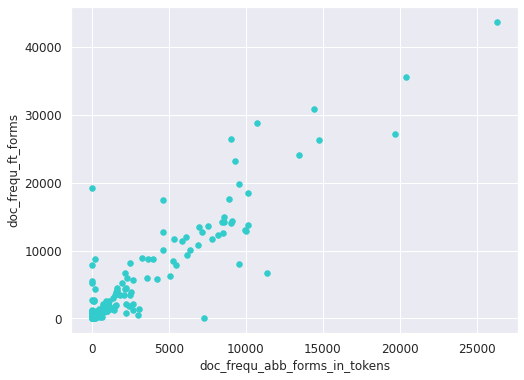

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rc('legend', fontsize=12)    # legend fontsize

df_abbrev[(df_abbrev['Category'] == 'Contraction')].plot.scatter(x='doc_frequ_abb_forms_in_tokens', y='doc_frequ_ft_forms',  s=30,color='#33cccc');


### Expressions - full-text to be replaced by the abbreviation

In [ ]:
df_abbrev.sort_values(by = 'doc_frequ_abb_forms_in_tokens', ascending = False)[(df_abbrev['Category2'] == 'Expression')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Abbreviation                                          Full-Text  \
ID                                                                    
317           IF                                   Intermediate Fix   
424           SO                                     Second Officer   
206          ATC                                Air Traffic Control   
290           FO                                      First Officer   
464        MILES                                       Statute Mile   
463        MILES                                      Nautical Mile   
451          VFR             Visual Flight Rules;Visual Flight Rule   
321          ILS                          Instrument Landing System   
319          IFR                            Instrument Flight Rules   
364          MSL                                     Mean Sea Level   
404          QRH                           Quick Reference Handbook   
271          FAR                        Federal Aviation Regulation   
187          AGL                                 Above Ground Level   
268          FAA                    Federal Aviation Administration   
289          FMS                           Flight Management System   
414         RNAV                                    Area Navigation   
397           PF                                       Pilot Flying   
209         ATIS             Automatic Terminal Information Service   
405           RA                                Resolution Advisory   
354          MEL                             Minimum Equipment List   
176        ACARS  Automatic Communications Addressing and Report...   
433         TCAS  Traffic Alert and Collision Avoidance System;T...   
304          GPS                          Global Positioning System   
257        EICAS         Engine Indicating and Crew Alerting System   
454          VMC  Visual Meteorological Conditions;Visual Meteor...   
177          ACR                                        Air Carrier   
196          APU                               Auxiliary Power Unit   
322          IMC               Instrument Meteorological Conditions   
332          LED                               Light Emitting Diode   
286          FMC                         Flight Management Computer   
272          FBO            Fixed-Base Operator;Fixed Base Operator   
421          SID                      Standard Instrument Departure   
389           PA                                     Public Address   
292          FPM                                    Feet Per Minute   
261        ENRTE                                           En Route   
247          DME                       Distance Measuring Equipment   
440       TRACON  Terminal Radar Approach Control Facility;Termi...   
254         ECAM         Electronic Centralized Aircraft Monitoring   
398          PIC                                   Pilot In Command   
240         CTAF                  Common Traffic Advisory Frequency   
429           TA                                   Traffic Advisory   
329         KIAS                           Knots Indicated Airspeed   
269          FAF                                 Final Approach Fix   
299          GAR                                          Go Around   
455         VNAV                                Vertical Navigation   
401          PNF                                   Pilot Not Flying   
347          MAP                              Missed Approach Point   
426         STAR                    Standard Terminal Arrival Route   
379        NOTAM                                   Notice To Airmen   
425          SOP                       Standard Operating Procedure   
338         LNAV                                 Lateral Navigation   
267           FA                                   Flight Attendant   
232          CFR                        Crash Fire Rescue Equipment   
305         GPWS                    Ground Proximity Warning System   
294          FSS            

In [ ]:
df_abbrev.sort_values(by = 'doc_frequ_ft_forms', ascending = False)[(df_abbrev['Category'] == 'Expression')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Abbreviation                                          Full-Text  \
ID                                                                    
290           FO                                      First Officer   
267           FA                                   Flight Attendant   
397           PF                                       Pilot Flying   
195     APCH_CTL                          APCH CTL;Approach Control   
299          GAR                                          Go Around   
300           GC                                     Ground Control   
282          FLC                                        Flight Crew   
225           CB                                    Circuit Breaker   
177          ACR                                        Air Carrier   
315          IAW                                 In Accordance With   
330           LC                                      Local Control   
401          PNF                                   Pilot Not Flying   
276           FD                                    Flight Director   
388          OTS                                     Out Of Service   
269          FAF                                 Final Approach Fix   
400       PLTDEV                                    Pilot Deviation   
200         ASAP                                As Soon As Possible   
261        ENRTE                                           En Route   
302      GND_SPD                               GND SPD;Ground Speed   
192       ALTDEV                                 Altitude Deviation   
206          ATC                                Air Traffic Control   
398          PIC                                   Pilot In Command   
226           CD                                 Clearance Delivery   
434          TDZ                                     Touchdown Zone   
416          RTO                                   Rejected Takeoff   
429           TA                                   Traffic Advisory   
437          TOD                                     Top Of Descent   
378        NORDO                                           No Radio   
281           FL                                       Flight Level   
462     XCOUNTRY                                      Cross Country   
399        PIREP                                       Pilot Report   
234          CIC                               Controller In Charge   
298           GA                                   General Aviation   
405           RA                                Resolution Advisory   
457      VOR_DME                        VOR/DME;VOR and DME;VOR-DME   
384           OM                                       Outer Marker   
339          LOA                                Letter Of Agreement   
404          QRH                           Quick Reference Handbook   
292          FPM                                    Feet Per Minute   
425          SOP                       Standard Operating Procedure   
411           RF                                    Radio Frequency   
311          IAF                               Initial Approach Fix   
216           BC                                        Back Course   
387      OPERROR                                  Operational Error   
178          ADC                                  Air Data Computer   
350          MCP                                 Mode Control Panel   
436          TOC                                       Top Of Climb   
363          MSA                              Minimum Safe Altitude   
463        MILES                                      Nautical Mile   
289          FMS                           Flight Management System   
347          MAP                              Missed Approach Point   
454          VMC  Visual Meteorological Conditions;Visual Meteor...   
220          CAB                                    Cabin Attendant   
375         NMAC                              Near Midair Collision   
305         GPWS            

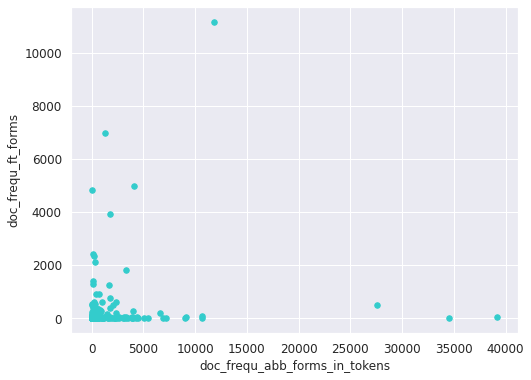

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rc('legend', fontsize=12)    # legend fontsize

df_abbrev[(df_abbrev['Category'] == 'Expression')].plot.scatter(x='doc_frequ_abb_forms_in_tokens', y='doc_frequ_ft_forms',  s=30,color='#33cccc');

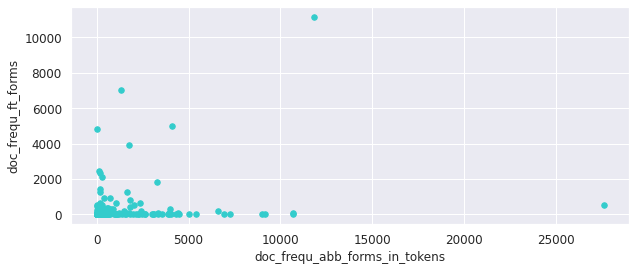

In [ ]:
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rc('legend', fontsize=12)    # legend fontsize

df_abbrev[(df_abbrev['Category'] == 'Expression')&(df_abbrev['Abbreviation'] !='IF')&(df_abbrev['Abbreviation'] !='SO')].plot.scatter(x='doc_frequ_abb_forms_in_tokens', y='doc_frequ_ft_forms',  s=30,color='#33cccc');

### 1 Letter / Unit - ReGex ?

In [ ]:
df_abbrev.sort_values(by = 'doc_frequ_abb_forms_in_tokens', ascending = False)[(df_abbrev['Category'] == '1 letter')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Abbreviation                    Full-Text  Category Category2  \
ID                                                                 
5             R                        Right  1 letter       NaN   
6             L                         Left  1 letter       NaN   
3             S                        South  1 letter       NaN   
1             E                         East  1 letter       NaN   
7             C                      Celsius  1 letter       NaN   
2             N                        North  1 letter       NaN   
4             W                         West  1 letter       NaN   
11            Z   Coordinated Universal Time  1 letter       NaN   
8             F                   Fahrenheit  1 letter       NaN   
10            G  Wind indication with Number  1 letter       NaN   
9             M                         Mach  1 letter       NaN   

   Forms to parse                Note Abbreviation+Forms to parse  \
ID                                                                  
5             NaN      split from L/R                           R   
6             NaN      split from L/R                           L   
3             NaN  Split from N,S,E,W                           S   
1             NaN  Split from N,S,E,W                           E   
7             NaN                 NaN                           C   
2             NaN  Split from N,S,E,W                           N   
4             NaN  Split from N,S,E,W                           W   
11            NaN                 NaN                           Z   
8             NaN                 NaN                           F   
10            NaN                 NaN                           G   
9             NaN                 NaN                           M   

   Abbreviation forms list  doc_frequ_naive_abb  \
ID                                                
5                      [R]               108384   
6                      [L]               108355   
3                      [S]               108324   
1                      [E]               108402   
7                      [C]               108244   
2                      [N]               108397   
4                      [W]               108027   
11                     [Z]                54168   
8                      [F]               108163   
10                     [G]               107998   
9                      [M]               107797   

    doc_frequ_abb_forms_in_tokens  doc_frequ_ft_forms  
ID                                                     
5                           11076               23586  
6                           10588               22677  
3                            6385                7693  
1                            4595               11349  
7                            4309                 151  
2                            3654                8000  
4                            3014                7797  
11                           1671                   0  
8                            1577                  55  
10                           1284                   0  
9                             722                1180

In [ ]:
df_abbrev.sort_values(by = 'doc_frequ_abb_forms_in_tokens', ascending = False)[(df_abbrev['Category'] == 'Unit')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Abbreviation      Full-Text Category    Category2 Forms to parse  \
ID                                                                    
13           FT           Feet     Unit  Contraction            NaN   
14           AM  Ante_Meridiem     Unit  Contraction            NaN   
12           KT          Knots     Unit  Contraction             ;S   
19          MIN         Minute     Unit  Contraction             ;S   
16           MI          Miles     Unit  Contraction            NaN   
20           HR           Hour     Unit  Contraction          ;S;LY   
17           NM          MILES     Unit  Contraction            NaN   
21           LB          Pound     Unit  Contraction             ;S   
15           PM  Post_Meridiem     Unit  Contraction            NaN   
18           SM          MILES     Unit  Contraction            NaN   
30          MHZ      Megahertz     Unit  Contraction            NaN   
25           KG       Kilogram     Unit  Contraction            NaN   
27           KM     Kilometers     Unit  Contraction            NaN   
29           MB      Millibars     Unit  Contraction            NaN   
24           HZ          Hertz     Unit  Contraction            NaN   
22           DB        Decibel     Unit  Contraction            NaN   
26          KHZ      Kilohertz     Unit  Contraction            NaN   
28           KW       Kilowatt     Unit  Contraction            NaN   
23          GHZ      Gigahertz     Unit  Contraction            NaN   

                         Note Abbreviation+Forms to parse  \
ID                                                          
13  2 lignes pour Feet / Foot                          FT   
14                        NaN                          AM   
12                        NaN                        KT;S   
19                        NaN                       MIN;S   
16                        NaN                          MI   
20                        NaN                     HR;S;LY   
17                        NaN                          NM   
21                        NaN                        LB;S   
15                        NaN                          PM   
18                        NaN                          SM   
30                        NaN                         MHZ   
25                        NaN                          KG   
27                        NaN                          KM   
29                        NaN                          MB   
24                        NaN                          HZ   
22                        NaN                          DB   
26                        NaN                         KHZ   
28                        NaN                          KW   
23                        NaN                         GHZ   

   Abbreviation forms list  doc_frequ_naive_abb  \
ID                                                
13                    [FT]                96114   
14                    [AM]                64678   
12               [KT, KTS]                 9956   
19             [MIN, MINS]                51629   
16                    [MI]                79171   
20         [HR, HRS, HRLY]                38555   
17                    [NM]                10174   
21               [LB, LBS]                17786   
15                    [PM]                 9417   
18                    [SM]                17829   
30                   [MHZ]                   72   
25                    [KG]                  732   
27                    [KM]                  245   
29                    [MB]                38794   
24                    [HZ]                  118   
22                    [DB]                 4281   
26                   [KHZ]                    1   
28                    [KW]                  809   
23                   [GHZ]                    2   

    doc_frequ_abb_forms_in_tokens  doc_frequ_ft_forms  
ID                                                     
13                          30382            